### TODO
0. For Feature Selection, we fit only on X and it fits only on Train Data - The scoring functions are however based on Time Series CV splits (which first fits the data on Train indices and then scores on Test Indices)
1. sample_weights - If we want to use strategy P&L as score, we can't assign maximum weights to "0" values in sample_weights
2. Outlier Detection & removal
3. Imputation
4. Create Score function - P&L - Based on Long Short position, position size and % return
5. Rectify Class Imbalance 
6. F1_score weighted looks odd - even when both precision_weighted and recall_weighted is lower, f1_weighed is higher?
7. Check each number in features_df!
8. If we put returns as Sample weights, he model will ignore all rows where returns equals 0 and that class will be under represented - Look at class_weight and sample_weight - However, if we do # 1, then sample_weights no longer reflect P&L and we want our score function to represent that


** Not able to pass sample_weight to transformation fit function

**autoreload script**

Getting data from CWP database & excel files::  33%|███▎      | 1/3 [00:04<00:08,  4.02s/it]

Time Taken for Contract:1 00:04


Getting data from CWP database & excel files::  67%|██████▋   | 2/3 [00:07<00:03,  3.41s/it]

Time Taken for Contract:2 00:07


Getting data from CWP database & excel files:: 100%|██████████| 3/3 [00:09<00:00,  3.27s/it]

Time Taken for Contract:3 00:09


Labels
 0        1161
 1         782
-1         739
dtype: int64


Getting data from CWP database & excel files::  33%|███▎      | 1/3 [00:03<00:06,  3.43s/it]

Time Taken for Contract:1 00:03


Getting data from CWP database & excel files::  67%|██████▋   | 2/3 [00:06<00:03,  3.24s/it]

Time Taken for Contract:2 00:06


Getting data from CWP database & excel files:: 100%|██████████| 3/3 [00:09<00:00,  3.18s/it]

Time Taken for Contract:3 00:09


Labels
 0        1161
 1         782
-1         739
dtype: int64


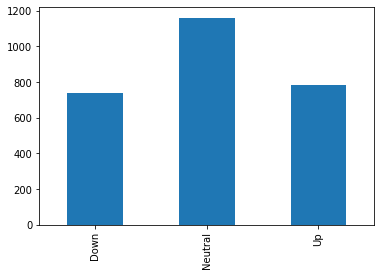

In [64]:
# %reload_ext autoreload
# %autoreload 2

# import _model_build_func
# import importlib
# importlib.reload(_model_build_func)
# from _model_build_func import *

**Functions List**
1. metrics_from_cm(cm, lab = sorted(Response['Labels'].unique()))  - return df          
2. predictions_from_custom_cross_val(model,X, y, custom_cv = BlockingTimeSeriesSplit(n_splits=5), sampled_weights=False) - returns original, predicted
3. probabilities_from_custom_cross_val(model,X, y, custom_cv = BlockingTimeSeriesSplit(n_splits=5), sampled_weights=False) - returns original, predicted_proba


In [65]:
# Takes 3.30 minutes to run
import warnings
warnings.filterwarnings('ignore')
from support._model_build_func import *


### Steps in Getting Processed Data

1. Get Raw data from Excel
2. Imputing Values for missing values - Backfilling and then frontfilling Variables DataFrame, and filling zeros with Median? - Check if it makes sense
3. Adding Date Features
4. Adding Technical Indicator Features
5. Replacing punctuation strings in column names
6. Finding Last Available Date for each column
7. For now using custom based method - but change it eventually with KNN (or Multivariate) Imputation etc.- # Takes 35 secounds to run
8. Remove Variables with all NaNs
9. Change Bool cols (mostly date columns such as Is_year_end etc.) to int columns
10. Winsorzing/Capping ['Adj_ret_2', 'Close_ret'] - **Instead of capping Adj_ret_2/Close_ret - try to figure out why we see abnormal returns such as -40% and +27%** - We don't now since using different adjustment methods

In [292]:
Variables = Variables_.copy(deep=True)
Response = Response_.copy(deep=True)
Variables_midx = Variables_midx_.copy(deep=True)
last_valid_loc = last_valid_loc_.copy(deep=True)
Variables_with_nans = Variables_with_nans_

len(Variables), len(Response), Variables.shape, Response.shape

(2682, 2682, (2682, 725), (2682, 8))

### MultiClassification Targets - Choose between 3 or 5 classes

In [67]:
Response.Adj_ret_3.max(), Response.Adj_ret_3.min(), Response.Close_3.max(), Response.Close_3.min()
# Response.iloc[Response.Close_3.argmax()], Response.iloc[Response.Close_3.argmin()]

(0.1037625697130806, -0.09252264990408168, 1670.5, 216.2)

### Change Sample weights
###### If you pull it from model_build_func.py, it runs everything so takes long time

In [ ]:

# choices 0,1,2 or
def assign_weights(Response,col = 'Adj_ret_3',choice=0):

    # Weights based on returns
    sample_weights = 1 + np.abs(Response[col].values)
    Response['sample_weights'] = sample_weights   

    if choice == 0:
        return Response
    elif choice == 1:
        # Assign max weights when returns are equal to 0. 
        Response.loc[Response[col] == 0, 'sample_weights'] = Response.sample_weights.max()
        return Response

    elif choice == 2:
        # This redistributes weights for Labels == 0  to max at 1 and then declining both sides till it reaches pv_2 on right/left side.
        Response.loc[Response.Labels == 0, 'sample_weights'] = Response.sample_weights.max()/(1 + np.abs(Response[Response.Labels == 0][col].values))
        return Response

    elif choice == 3:
        #Combines choice 2 and another weighing based on class weights
        # This redistributes weights for Labels == 0  to max at 1 and then declining both sides till it reaches pv_2 on right/left side.
        Response.loc[Response.Labels == 0, 'sample_weights'] = Response.sample_weights.max()/(1 + np.abs(Response[Response.Labels == 0][col].values))
        
        num_labels = len(Response.Labels.unique())-1
        # Inorder to make sure each class has equal weights in aggregate we multiply each class by (sum of counts of other two classes/2 times all 3 classes counts)
        for l in Response.Labels.unique():
            Response.loc[Response.Labels == l, 'sample_weights'] = Response.loc[Response.Labels == l, 'sample_weights'] * (len(Response[Response.Labels != l])/(num_labels*len(Response)))
        return Response
    
    else:
        print("Wrong option entered for assign_weights")

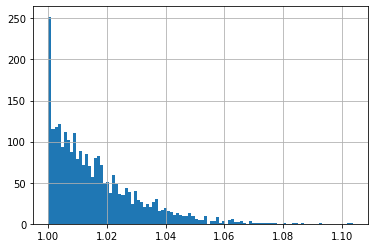

In [85]:
Response_0 = Response_.copy(deep=True)
Response_0 = assign_weights(Response_0,col = 'Adj_ret_3',choice=0)
Response_0.sample_weights.hist(bins=100);

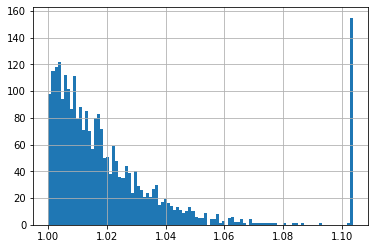

In [86]:
Response_1 = Response_.copy(deep=True)
Response_1 = assign_weights(Response_1,col = 'Adj_ret_3',choice=1)
Response_1.sample_weights.hist(bins=100);

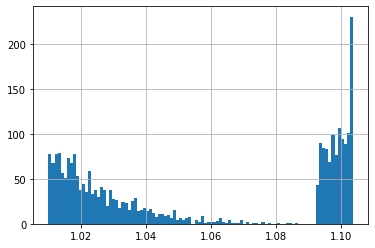

In [87]:
Response_2 = Response_.copy(deep=True)
Response_2 = assign_weights(Response_2,col = 'Adj_ret_3',choice=2)
Response_2.sample_weights.hist(bins=100);

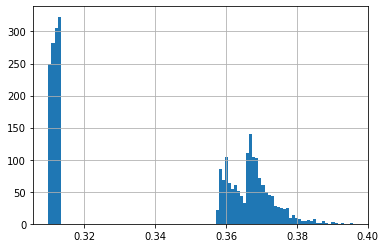

In [88]:
Response_3 = Response_.copy(deep=True)
Response_3 = assign_weights(Response_3,col = 'Adj_ret_3',choice=3)
Response_3.sample_weights.hist(bins=100);

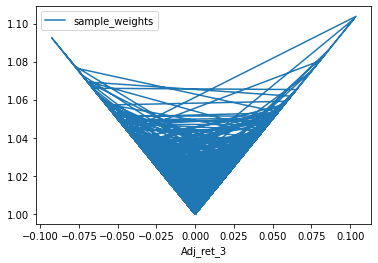

In [89]:
Response_0.plot(x='Adj_ret_3', y = 'sample_weights');

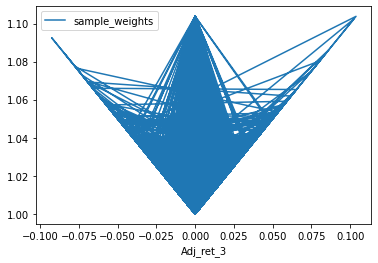

In [90]:
Response_1.plot(x='Adj_ret_3', y = 'sample_weights');

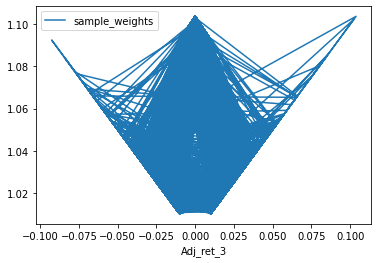

In [91]:
Response_2.plot(x='Adj_ret_3', y = 'sample_weights');

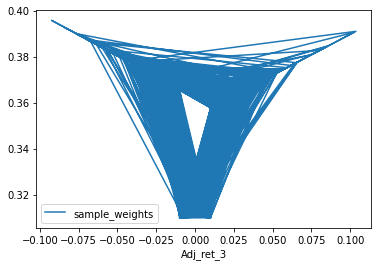

In [92]:
Response_3.plot(x='Adj_ret_3', y = 'sample_weights');

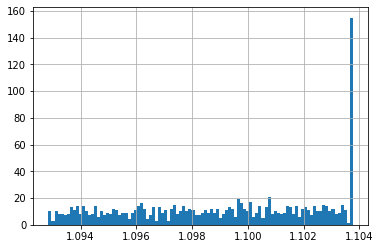

In [96]:
# For Class 0/Neutral, what are sample weights?
Response_2[Response_2.Labels == 0].sample_weights.hist(bins=100);

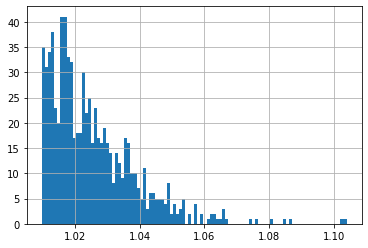

In [97]:
Response_2[Response_2.Labels == 1].sample_weights.hist(bins=100);

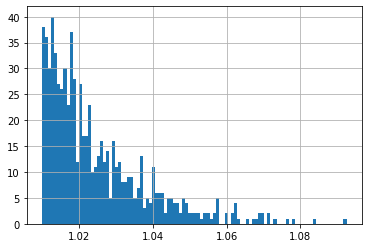

In [98]:
Response_2[Response_2.Labels == -1].sample_weights.hist(bins=100);

### Adding Engineered Variables

In [ ]:
# Add engineered variables to this list

emginereed_list = ['NetSpecLength','InvByOrder', 'lumbermovingaverages MA200', 'lumbermovingaverages MA30','LumberAdjusteddfs BasisByDte2',
                'LumberContractSpreads FirstSecond', 'Investingdotcom USMBAPurchaseIndex', 'OverNightRates EFFR',]

def add_engineered_variables(df1,var1,var2,func,new_name):
    df = df1.copy(deep=True)
    df[new_name] = func(df[var1],df[var2])
    return df

# 1. NET SPEC LENGTH, difference(1), no lags or roll
var1 = "CFTCdisaggregated PctofOIMMoneyLongAll"
var2 = "CFTCdisaggregated PctofOIMMoneyShortAll"
feat_name_ = 'NetSpecLength'
#inplace operation
Variables = add_engineered_variables(Variables,var1,var2,func=np.subtract,new_name=feat_name_)

# This is for calculating the change in the variable rather than absolute value
Variables[feat_name_] = Variables[feat_name_].sort_index(ascending=True).diff().replace(np.nan,0)


# 2. Inventory By Order, difference(1), 5 day lags
var1 = "WesternLumberinventorywestern WesternTotal"
var2 = "WesternLumberorderswestern WesternTotal"
feat_name_ = 'InvByOrder'
#inplace operation
Variables = add_engineered_variables(Variables,var1,var2,func=np.divide,new_name=feat_name_)
# Variables[feat_name_] = Variables[feat_name_].sort_index(ascending=True).pct_change().replace(np.nan,0)
# Variables[feat_name_] = Variables[feat_name_][:30].sort_index(ascending=True).rolling(5).mean().fillna(0)

In [ ]:
Variables[emginereed_list][:10]

### Splitting the Dataset in 3 Dictionaries of Training, Testing & Validation & Initiating features_df

###### Note: If metric calculations in add_metric function is calculated on Data which has even one class missing from y_predictions, it will throw an error (when error='raise' used), or it will be NaN for (roc_auc_ovr_weighted & roc_auc_ovo_weighted) if this option is not used in cross_val_score..


In [279]:
X_train_dict, X_test_dict, X_val_dict, y_train, y_test, y_val, sample_weights_train, sample_weights_test, sample_weights_val \
    = ttv_split(Variables, Response, test_size=0.50, Validation_date_start = '2022-01-01')

In [100]:
len(Variables), len(Variables_with_nans)

(2682, 6)

<div style="color: Green; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> Check why these variables have NaNs
</div>


In [101]:
last_valid_loc[last_valid_loc.isna().any(axis=1)] # same as Variables_with_nans

End_Dt
Lumber_Track_north_american_production Prairies_And_Eastern_Canada              NaT
                                       Total_North_America                      NaT
Lumber_Track_north_american_shipment   Prairies_And_Eastern_Canada              NaT
                                       Total_North_America                      NaT
CFTC_legacy                            Total_Reportable_Positions_Long_All      NaT
                                       Concentration_Gross_LT_4_TDR_Short_Ol    NaT

In [102]:
print("Variable Types")
print(pd.Series(Variables.dtypes.values).value_counts())
print("Total Variables:",pd.Series(Variables.dtypes.values).value_counts().sum())

print('\n')
print("Response Types")
print(pd.Series(Response.dtypes.values).value_counts())


Variable Types
float64    708
int64       10
int32        7
dtype: int64
Total Variables: 725


Response Types
float64    7
int32      1
dtype: int64


### Sample weights - Removed Outliers from Response by replacing with IQR*1.5 upper and lower limits

In [103]:
col = 'Adj_ret_3'
create_bins_data(Response, col, 10)

Max: 0.1037625697130806
Min: -0.09252264990408168


(-0.0935, -0.0707]      0.26
(-0.0707, -0.0489]      1.53
(-0.0489, -0.0271]      7.01
(-0.0271, -0.00528]    27.67
(-0.00528, 0.0165]     42.54
(0.0165, 0.0383]       16.67
(0.0383, 0.0601]        3.65
(0.0601, 0.082]         0.52
(0.082, 0.104]          0.15
Name: Adj_ret_3, dtype: float64

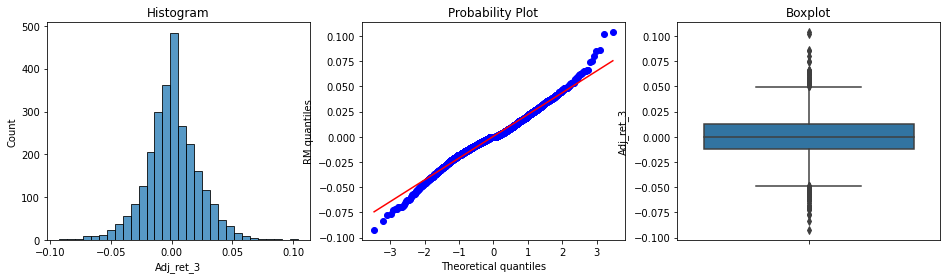

In [104]:
diagnostic_plots(Response, col)

In [105]:
# Response['sample_weights'] = Response.sample_weights.values * (Response.Labels.value_counts().sum()/2)

In [106]:
Response.Labels.value_counts()

 0    1161
 1     782
-1     739
Name: Labels, dtype: int64

In [107]:
# print(winsoriser.left_tail_caps_)
# print(winsoriser.right_tail_caps_)

print(Response[['Labels','sample_weights']].groupby('Labels').sum())
print(Response[['Labels','sample_weights']].groupby('Labels').mean())

        sample_weights
Labels                
-1          757.169760
 0         1281.468343
 1          802.007873
        sample_weights
Labels                
-1            1.024587
 0            1.103763
 1            1.025586


In [108]:
Response[['Labels']].value_counts()/len(Response)

Labels
 0        0.432886
 1        0.291573
-1        0.275541
dtype: float64

In [109]:
create_bins_data(Response, 'sample_weights', 10)

Max: 1.1037625697130806
Min: 1.0100000833345835


(1.0090000000000001, 1.02]    26.81
(1.02, 1.031]                 14.99
(1.031, 1.041]                 8.31
(1.041, 1.052]                 3.88
(1.052, 1.062]                 1.42
(1.062, 1.073]                 0.86
(1.073, 1.083]                 0.22
(1.083, 1.093]                 0.15
(1.093, 1.104]                43.36
Name: sample_weights, dtype: float64

### EVALUATION METRICS & generate_sample_confusion_matrix
    1. Recall/Sensitivity/TPR: tp / (tp + fn) - **%age of a TRUE/Positives class correctly identified/ ability to find all the positive samples**. This decides how many times we trade since its the propotion of actual positives we are able to detect.
    2. Specificity (TNR) is tn / (tn + fp) - %age of a FALSE/Negatives class correctly identified
    3. False Positive Rate (FPR) = 1 - Specificity or fp / (tn + fp). 
    4. Accuracy is TP+ TN/ entire matrix sum - only for Binary classification
    5. Precision is tp / (tp + fp) - the ability not to label a negative sample as positive. This decides our PROFITABILITY since we don't want FALSE Positives
    6. Support is the number of occurrences of each class  - sum of respective row
    7. Macro - unweighted mean. This does not take label imbalance into account.
    8. Wt_Avg - average weighted by support
    9. Micro - same as accuracy - sum of diagnols/ sum of all matrix

**True/False (Positives/Negatives) means if a sample belongs/doesn't belong to a class**


In [110]:
lab = Response.Labels.unique()
lab.sort()

generate_sample_confusion_matrix(-1,lab)

In [111]:
lab

array([-1,  0,  1])

### Blocked Time Series cross-validation
https://goldinlocks.github.io/Time-Series-Cross-Validation/

In [112]:
btscv = BlockingTimeSeriesSplit(n_splits=5)

**Metrics from Confusion Matrix Custom Func - These metrics (weighted & average) do NOT exactly match the output of features_df metrics** 
** Also note that the weighted average results are not based on sample_weights for now

In [113]:
# RAJA 

# X = pd.concat([X_train_dict['Original'], X_test_dict['Original']], axis=0)
# y = pd.concat([y_train, y_test], axis=0)
# X.shape, y.shape
# model = models[0]
# train_idx  = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = False)['train']
# test_idx = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = False)['test']

# # Issue with shape - need to correct 
# predicted_proba1 = []
# for i in range(len(train_idx)):
#     model.fit(X.iloc[train_idx[i]], y.Labels.iloc[train_idx[i]])
#     predicted_proba1.append(model.predict_proba(X.iloc[test_idx[i]]))

### Helper Functions

In [114]:
# This func is only to initialize the X variables with some features set - typically, we use 'Original' if not passed in
def fill_with_dataset(dataset,manual_list, original_dataset = 'Original'):
    if manual_list:
        X_train_dict[dataset] = X_train_dict[original_dataset][manual_list]
        X_test_dict[dataset] = X_test_dict[original_dataset][manual_list]
        X_val_dict[dataset] = X_val_dict[original_dataset][manual_list]
        
    else:
        X_train_dict[dataset] = X_train_dict[original_dataset]
        X_test_dict[dataset] = X_test_dict[original_dataset]
        X_val_dict[dataset] = X_val_dict[original_dataset]

In [115]:
# this func first fits the transformation to all indices of X_train from cv (btscv), then transforms the features from X_train, X_test and X_val
# For each pipeline trasnformation, we are using same sample_weights_train - Not working
def transform_features_space(dataset,pipe,sampled_weights=False):
    print("\nRemoving Features for dataset:",dataset)
    print("# Features before:",len(X_train_dict[dataset].columns.to_list()))
    
    X, y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test,set='combined')
    train_idx = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = True)['train']
    
    # Since this is not working sampled_weights True is same as False
    if sampled_weights:

        # NOT WORKING
        # parameters = {pipe.steps[i][0] + "__sample_weight": y.iloc[train_idx].sample_weights.values for i in range(len(pipe.steps))}
        # pipe.fit(X.iloc[train_idx], **parameters)
        pipe.fit(X.iloc[train_idx])
    else:
        pipe.fit(X.iloc[train_idx])
        
    X_train_dict[dataset] = pipe.transform(X_train_dict[dataset])
    X_test_dict[dataset] = pipe.transform(X_test_dict[dataset])
    X_val_dict[dataset] = pipe.transform(X_val_dict[dataset])

In [116]:
def add_to_features_df(model,dataset):
    model_name = type(model).__name__
    features_df.loc[(model_name, dataset),'Num_Features'] = len(X_train_dict[dataset].columns) # so can store list of features
    features_df.loc[(model_name, dataset),'Features_List'] = X_train_dict[dataset].columns.to_list()

    original_list = set(features_df.loc[(model_name, 'Original'),'Features_List'])
    dataset_list = set(features_df.loc[(model_name, dataset),'Features_List'])
    removed_list = list(sorted(original_list - dataset_list))
    
    features_df.loc[(model_name, dataset),'Removed_Features'] = removed_list
    features_df.loc[(model_name, dataset),'Model_Details'] = model

def get_shapes(dataset):
    # print("\nShapes for dataset:",dataset)
    print("X_train Shape",X_train_dict[dataset].shape)
    print("X_test Shape",X_test_dict[dataset].shape)
    print("X_val Shape",X_val_dict[dataset].shape)
    # print("y_train Shape",y_train.shape)
    # print("y_test Shape",y_test.shape)
    # print("y_val Shape",y_val.shape)

def print_pipe_removed(pipe):
    total_removed = 0
    # print("\nRemoved Features for Pipeline:",pipe)
    for i in range(len(pipe.steps)):
        step_name = pipe.steps[i][0]
        total_removed += len(pipe.named_steps[step_name].features_to_drop_)
        print(step_name, ":",len(pipe.named_steps[step_name].features_to_drop_))
    print("Total removed:",total_removed)

# Calls all the above 3 functions
def insert_and_print(model,dataset,pipe, manual_list):
    print("\nInserting Pipeline for dataset:",dataset)

    # This code INSERTS model's basic data into features_df
    add_to_features_df(model,dataset)

    # This code PRINTS X variables Shape
    get_shapes(dataset)

    # This code prints the features removed for each pipe step
    if not manual_list: print_pipe_removed(pipe)
  


In [117]:
# # https://stackoverflow.com/questions/42562146/classification-report-with-nested-cross-validation-in-sklearn-average-individua
# def predictions_from_custom_cross_val(model,X, y, custom_cv = BlockingTimeSeriesSplit(n_splits=5), sampled_weights=False):    
#     # Variables to store original and predicted values
#     original = []
#     predicted = []

#     def score_func(y_true, y_pred):
#         original.extend(y_true)
#         predicted.extend(y_pred)

#     if sampled_weights:
#     # Cross Val Score with SAMPLE WeIGHTS        
#         scores = cross_val_score(model, X, y.Labels, cv=custom_cv, scoring=make_scorer(score_func),fit_params={'sample_weight':y.sample_weights.values} ) #,error_score="raise"
#     else:
#         scores = cross_val_score(model, X, y.Labels, cv=custom_cv, scoring=make_scorer(score_func) ) #,error_score="raise"
#     return original, predicted



*****Change between Labels & Close_Up_Down columns for y_combined to make it either a Multiclass (5) or (3)***

### NEW WORK

#### Change Sample weights
###### If you pull it from model_build_func.py, it runs everything so takes long time

In [ ]:

# choices 0,1,2 or
def assign_weights(Response,col = 'Adj_ret_3',choice=0):

    # Weights based on returns
    sample_weights = 1 + np.abs(Response[col].values)
    Response['sample_weights'] = sample_weights   

    if choice == 0:
        return Response
    elif choice == 1:
        # Assign max weights when returns are equal to 0. 
        Response.loc[Response[col] == 0, 'sample_weights'] = Response.sample_weights.max()
        return Response

    elif choice == 2:
        # This redistributes weights for Labels == 0  to max at 1 and then declining both sides till it reaches pv_2 on right/left side.
        Response.loc[Response.Labels == 0, 'sample_weights'] = Response.sample_weights.max()/(1 + np.abs(Response[Response.Labels == 0][col].values))

    elif choice == 3:
        #Combines choice 2 and another weighing based on class weights
        # This redistributes weights for Labels == 0  to max at 1 and then declining both sides till it reaches pv_2 on right/left side.
        Response.loc[Response.Labels == 0, 'sample_weights'] = Response.sample_weights.max()/(1 + np.abs(Response[Response.Labels == 0][col].values))
        
        num_labels = len(Response.Labels.unique())-1
        # Inorder to make sure each class has equal weights in aggregate we multiply each class by (sum of counts of other two classes/2 times all 3 classes counts)
        for l in Response.Labels.unique():
            Response.loc[Response.Labels == l, 'sample_weights'] = Response.loc[Response.Labels == l, 'sample_weights'] * (len(Response[Response.Labels != l])/(num_labels*len(Response)))
        return Response
    
    else:
        print("Wrong option entered for assign_weights")

In [468]:

from sklearn.metrics import confusion_matrix

Variables = Variables_.copy(deep=True)
Response = Response_.copy(deep=True)

X_train_dict, X_test_dict, X_val_dict, y_train, y_test, y_val, sample_weights_train, sample_weights_test, sample_weights_val \
    = ttv_split(Variables, Response, test_size=0.50, Validation_date_start = '2022-01-01')

dataset = 'Original'
X, y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')
model = RandomForestClassifier(n_estimators=20, max_depth=3, n_jobs=-1, random_state=1)

sampled_weights = True
original, predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv, sampled_weights=sampled_weights)
cm = pd.DataFrame(confusion_matrix(original, predicted,normalize=None,labels =lab), index=lab, columns=lab)
cm_metric = metrics_from_cm(cm, lab = sorted(Response['Labels'].unique()))
cm

,-1,0,1
-1,60,64,7
0,49,160,9
1,70,77,9


In [476]:
for n in lab:
 print(n,":",cm.loc[n].sum(), original.count(n))

-1 : 131 131
0 : 218 218
1 : 156 156


In [479]:
from yellowbrick.classifier import ConfusionMatrix

Variables = Variables_.copy(deep=True)
Response = Response_.copy(deep=True)

X_train_dict, X_test_dict, X_val_dict, y_train, y_test, y_val, sample_weights_train, sample_weights_test, sample_weights_val \
    = ttv_split(Variables, Response, test_size=0.50, Validation_date_start = '2022-01-01')

dataset = 'Original'
X, y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')
train_idx = [get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5,flatten=False)['train']][0]
test_idx = [get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5,flatten=False)['test']][0]
cm_matrix = pd.DataFrame(0, columns=lab,index=lab)
cm_yellow = None
for tr_idx,te_idx in zip(train_idx,test_idx):
    X_train = X.iloc[tr_idx].values.reshape(len(tr_idx),-1)
    X_test = X.iloc[te_idx].values.reshape(len(te_idx),-1)
    y_train = y.iloc[tr_idx]['Labels'].values.reshape(-1,1)
    y_test = y.iloc[te_idx]['Labels'].values.reshape(-1,1)

    y_test = [x for xs in y_test for x in xs]
    y_train = [x for xs in y_train for x in xs]
    model = RandomForestClassifier(n_estimators=20, max_depth=3, n_jobs=-1, random_state=1)
    cm_yellow = ConfusionMatrix(model)
    cm_yellow.fit(X_train,y_train,sample_weight = y.sample_weights.iloc[tr_idx].values.tolist())
    cm_yellow.score(X_test,y_test)
    cm_matrix = cm_matrix + pd.DataFrame(cm_yellow.confusion_matrix_,columns=cm_matrix.columns,index=cm_matrix.index)

plt.clf();
cm_metric_yellow = metrics_from_cm(cm_matrix, lab = lab)
cm_matrix


,-1,0,1
-1,60,64,7
0,49,160,9
1,70,77,9


<Figure size 576x396 with 0 Axes>

In [480]:
test_idx = [get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5,flatten=True)['test']][0]
y_test = y.iloc[test_idx]
# y_test = [x for xs in y_test for x in xs]


In [481]:
y_test.Labels.value_counts()

 0    218
 1    156
-1    131
Name: Labels, dtype: int64

In [327]:
cm_metric_yellow

,precision,recall,fscore,specificity,fpr,accuracy,tp,tn,fp,fn,support
-1,34%,46%,39%,68%,32%,62%,60.0,255.0,119.0,71.0,131.0
0,53%,73%,62%,51%,49%,61%,160.0,146.0,141.0,58.0,218.0
1,36%,6%,10%,95%,5%,68%,9.0,333.0,16.0,147.0,156.0
macro,41%,42%,37%,71%,29%,64%,229.0,734.0,276.0,276.0,505.0
Wt_Avg,43%,45%,40%,69%,31%,63%,229.0,734.0,276.0,276.0,505.0


In [357]:
Response['Labels'].unique()

array([ 0, -1,  1])

In [487]:
cm_matrix

,-1,0,1
-1,60,64,7
0,49,160,9
1,70,77,9


In [486]:
cm_matrix.sum(axis=0)

-1    179
 0    301
 1     25
dtype: int64

In [489]:
cm_matrix.sum(axis=1)

-1    131
 0    218
 1    156
dtype: int64

In [490]:
cm_matrix

,-1,0,1
-1,60,64,7
0,49,160,9
1,70,77,9


In [492]:
49+70

119

In [452]:
# This is wrongly labeled - instead of showing -1,0,1 - its actually showing 0,-1,1 - change it appropriately - down looks ok???
cm_metric_yellow

,precision,recall,fscore,specificity,fpr,accuracy,tp,tn,fp,fn,support
-1,34%,46%,39%,68%,32%,62%,60.0,255.0,119.0,71.0,131.0
0,53%,73%,62%,51%,49%,61%,160.0,146.0,141.0,58.0,218.0
1,36%,6%,10%,95%,5%,68%,9.0,333.0,16.0,147.0,156.0
macro,41%,42%,37%,71%,29%,64%,229.0,734.0,276.0,276.0,505.0
Wt_Avg,43%,45%,40%,69%,31%,63%,229.0,734.0,276.0,276.0,505.0


### It calculates scores for each set(5) of btscv index for test - check if we need to compare to manual method - otherwise skip
#### Also can use different scoring by using make_scorer - but first check if we require this

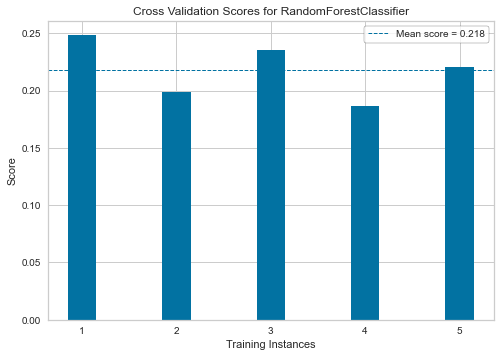

In [365]:
# For scoring - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
from sklearn.metrics import make_scorer

from yellowbrick.model_selection import CVScores
# btscv = BlockingTimeSeriesSplit(n_splits=5)
scoring = 'f1_macro'
visualizer = CVScores(model, cv=btscv, scoring= scoring)
visualizer.fit(X,y.Labels)
# visualizer.score(X_test1,y_test1)
visualizer.show();

In [497]:
dataset = 'Original'
model = RandomForestClassifier(n_estimators=20, max_depth=3, n_jobs=-1, random_state=1)

Variables = Variables_.copy(deep=True)
Response = Response_.copy(deep=True)

X_train_dict, X_test_dict, X_val_dict, y_train, y_test, y_val, sample_weights_train, sample_weights_test, sample_weights_val \
    = ttv_split(Variables, Response, test_size=0.50, Validation_date_start = '2022-01-01')

dataset = 'Original'
X, y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')
sampled_weights = False
original_ns, predicted_ns = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv, sampled_weights=sampled_weights)

In [498]:
len(predicted_ns), len(X)

(505, 2519)

In [499]:
cm_noweight= pd.DataFrame(confusion_matrix(original_ns, predicted_ns,normalize=None), index=lab, columns=lab)
print(cm_noweight.sum().sum())
cm_noweight

505


,-1,0,1
-1,59,62,10
0,55,157,6
1,71,78,7


In [500]:
y_test_weights = y.iloc[get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5,flatten=True)['test']]['sample_weights']
len(y_test_weights), sum(y_test_weights)

(505, 534.6232914234721)

In [501]:
cm_weight = pd.DataFrame(confusion_matrix(original_ns, predicted_ns,normalize=None,sample_weight=y_test_weights.values), index=lab, columns=lab)
print(cm_weight.sum().sum())
print(sum(y_test_weights))
cm_weight

534.623291423473
534.6232914234721


,-1,0,1
-1,60.641306,63.116414,10.259168
0,60.706941,173.290723,6.622575
1,73.274701,79.517296,7.194165


In [502]:
metrics_from_cm(cm_noweight, lab = sorted(Response['Labels'].unique()))

,precision,recall,fscore,specificity,fpr,accuracy,tp,tn,fp,fn,support
-1,32%,45%,37%,66%,34%,61%,59.0,248.0,126.0,72.0,131.0
0,53%,72%,61%,51%,49%,60%,157.0,147.0,140.0,61.0,218.0
1,30%,4%,8%,95%,5%,67%,7.0,333.0,16.0,149.0,156.0
macro,38%,41%,35%,71%,29%,63%,223.0,728.0,282.0,282.0,505.0
Wt_Avg,40%,44%,38%,69%,31%,63%,223.0,728.0,282.0,282.0,505.0


In [503]:
metrics_from_cm(cm_weight, lab = sorted(Response['Labels'].unique()))

,precision,recall,fscore,specificity,fpr,accuracy,tp,tn,fp,fn,support
-1,31%,45%,37%,67%,33%,61%,60.641306,266.624760,133.981643,73.375582,134.016888
0,55%,72%,62%,51%,49%,61%,173.290723,151.369341,142.633711,67.329517,240.620240
1,30%,4%,8%,95%,5%,68%,7.194165,357.755385,16.881743,152.791998,159.986163
macro,39%,41%,36%,71%,29%,63%,241.126195,775.749486,293.497097,293.497097,534.623291
Wt_Avg,41%,45%,40%,68%,32%,63%,241.126195,775.749486,293.497097,293.497097,534.623291


In [124]:
print(Response[['Labels','sample_weights']].groupby('Labels').sum())

        sample_weights
Labels                
-1          757.169760
 0         1281.468343
 1          802.007873


In [505]:
# Precision on the diagnal
cm_p = pd.DataFrame(confusion_matrix(original_ns, predicted_ns,normalize='pred',sample_weight=y_test_weights.values), index=lab, columns=lab)
print(np.diagonal(cm_p))
cm_p

[0.31158353 0.54851953 0.29881178]


,-1,0,1
-1,0.311584,0.199783,0.426118
0,0.311921,0.548520,0.275071
1,0.376496,0.251697,0.298812


In [378]:
metrics_from_cm(cm_p, lab = sorted(Response['Labels'].unique()))

,precision,recall,fscore,specificity,fpr,accuracy,tp,tn,fp,fn,support
-1,31%,33%,32%,67%,33%,56%,0.311584,1.374099,0.688416,0.625901,0.937484
0,55%,48%,51%,76%,24%,65%,0.548520,1.413009,0.451480,0.586991,1.135511
1,30%,32%,31%,66%,34%,56%,0.298812,1.371807,0.701188,0.628193,0.927005
macro,39%,38%,38%,70%,30%,59%,1.158915,4.158915,1.841085,1.841085,3.000000
Wt_Avg,40%,39%,39%,70%,30%,60%,1.158915,4.158915,1.841085,1.841085,3.000000


In [506]:
# Recall on the diagnal
cm_r = pd.DataFrame(confusion_matrix(original_ns, predicted_ns,normalize='true',sample_weight=y_test_weights.values), index=lab, columns=lab)
print(np.diagonal(cm_r))
cm_r

[0.45038168 0.72018349 0.04487179]


,-1,0,1
-1,0.450382,0.473282,0.076336
0,0.252294,0.720183,0.027523
1,0.455128,0.500000,0.044872


In [507]:
metrics_from_cm(cm_r, lab = sorted(Response['Labels'].unique()))

,precision,recall,fscore,specificity,fpr,accuracy,tp,tn,fp,fn,support
-1,39%,45%,42%,65%,35%,58%,0.450382,1.292578,0.707422,0.549618,1.0
0,43%,72%,53%,51%,49%,58%,0.720183,1.026718,0.973282,0.279817,1.0
1,30%,4%,8%,95%,5%,65%,0.044872,1.896141,0.103859,0.955128,1.0
macro,37%,41%,34%,70%,30%,60%,1.215437,4.215437,1.784563,1.784563,3.0
Wt_Avg,37%,41%,34%,70%,30%,60%,1.215437,4.215437,1.784563,1.784563,3.0


In [380]:
def get_cm_metrics(cm):
    cm_metric = pd.DataFrame(index=['Support','Recall','Precision'], columns=lab)
    for l in lab:
        lab_value = cm.loc[l,l]
        row_sum = cm.loc[[l],:].sum().sum()
        col_sum = cm.loc[:,[l]].sum().sum()
        cm_metric.loc['Support',l] = row_sum
        cm_metric.loc['Precision',l] = lab_value/col_sum*100
        cm_metric.loc['Recall',l] = lab_value/row_sum*100
        # print("Support {}:".format(l),row_sum)
        # print("Recall {}:".format(l),lab_value/row_sum*100)
        # print("Precision {}:".format(l),lab_value/col_sum*100)
    return cm_metric

get_cm_metrics(cm_matrix)

,-1,0,1
Support,131,218,156
Recall,45.801527,73.394495,5.769231
Precision,33.519553,53.156146,36.0


In [383]:
# tn, fp, fn, tp = confusion_matrix(original_ns, predicted_ns, ).ravel()

In [384]:
cm = pd.DataFrame(confusion_matrix(original_ns, predicted_ns,normalize='all'), index=lab, columns=lab)
print(cm.sum().sum())
cm

1.0


,-1,0,1
-1,0.116832,0.122772,0.019802
0,0.108911,0.310891,0.011881
1,0.140594,0.154455,0.013861


In [511]:
original.count(-1)/len(original), original.count(0)/len(original), original.count(1)/len(original)

(0.2594059405940594, 0.4316831683168317, 0.3089108910891089)

In [391]:
y_test_raw = y.iloc[get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5,flatten=True)['test']]['Labels']
compare_df_ns = pd.concat([y_test_raw,pd.DataFrame(data=original_ns,index=y_test_raw.index,columns=['original']),pd.DataFrame(data=predicted_ns,index=y_test_raw.index,columns=['predicted'])],axis=1)
print("Number of rows where predicted is not equal to original:",len(compare_df_ns[compare_df_ns['predicted'] != compare_df_ns['original']]))
compare_df_ns.head()

Number of rows where predicted is not equal to original 282


,Labels,original,predicted
2013-08-07,1,1,0
2013-08-08,0,0,0
2013-08-09,0,0,0
2013-08-12,0,0,0
2013-08-13,1,1,0


In [513]:
rf = RandomForestClassifier(random_state=1)
models =[rf]
model_names = [type(m).__name__ for m in models]
dataset = 'Original'
multilevel_index = pd.MultiIndex.from_product([model_names,[dataset]],names=['Model', 'Dataset'])
cols_names = ['Model_Details','Num_Features','Features_List','Removed_Features'] + ['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted','neg_log_loss','Kappa','pnl','sharpe','ClassDf']
features_df = pd.DataFrame(columns=cols_names, index=multilevel_index)

for m in models:
    add_to_features_df(m,dataset='Original')
    # add_metrics(model=m,dataset='Original',X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test,set='combined')

features_df

,,Model_Details,Num_Features,Features_List,Removed_Features,balanced_accuracy,precision_weighted,recall_weighted,f1_weighted,roc_auc_ovr_weighted,roc_auc_ovo_weighted,neg_log_loss,Kappa,pnl,sharpe,ClassDf
Model,Dataset,,,,,,,,,,,,,,,
RandomForestClassifier,Original,RandomForestClassifier(random_state=1),725,"[LumberOHLCV LBHigh, LumberOHLCV LBLow, Lumber...",[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [516]:
from yellowbrick.classifier import(ClassificationReport, DiscriminationThreshold)

from sklearn.metrics import (precision_score, recall_score, f1_score)

In [517]:
train_idx = [get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5,flatten=True)['train']][0]
test_idx = [get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5,flatten=True)['test']][0]

X_train1 = X.iloc[train_idx].values.reshape(len(train_idx),-1)
X_test1 = X.iloc[test_idx].values.reshape(len(test_idx),-1)
y_train1 = y.iloc[train_idx]['Labels'].values.reshape(-1,1)
y_test1 = y.iloc[test_idx]['Labels'].values.reshape(-1,1)

len(train_idx), len(test_idx),len(X), X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

(2010, 505, 2519, (2010, 725), (505, 725), (2010, 1), (505, 1))

In [518]:
# y.iloc[train_idx]['Labels'].values.tolist()

In [519]:
y_test1 = [x for xs in y_test1 for x in xs]
y_train1 = [x for xs in y_train1 for x in xs]
pd.DataFrame(y_test1).value_counts()

 0    218
 1    156
-1    131
dtype: int64

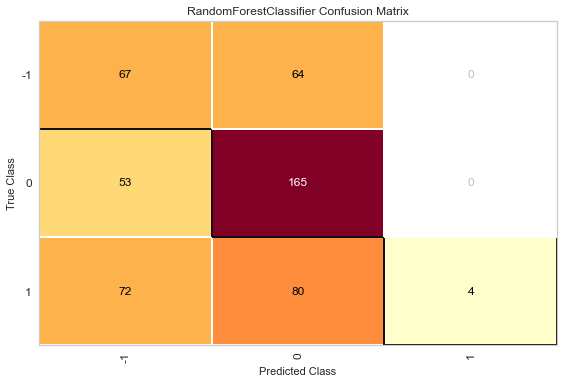

In [520]:
cm_y = ConfusionMatrix(model)
cm_y.fit(X_train1,y_train1)
cm_y.score(X_test1,y_test1)
cm_y.show();

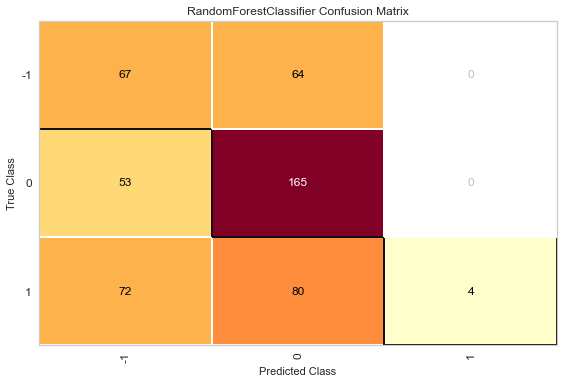

array([[ 67,  64,   0],
       [ 53, 165,   0],
       [ 72,  80,   4]], dtype=int64)

In [521]:

from yellowbrick.classifier import confusion_matrix
cm_y = confusion_matrix(model,X_train1, y_train1, X_test1, y_test1)
cm_y.confusion_matrix_

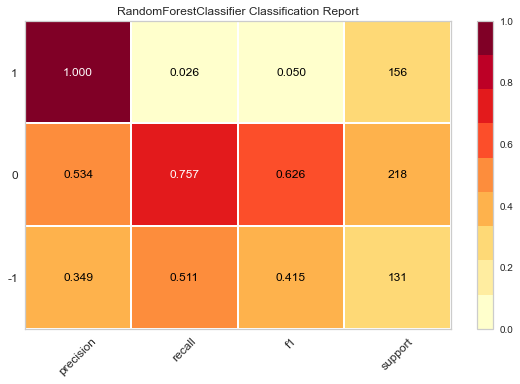

In [522]:
# visualizer = ClassificationReport(model,support=True)
visualizer = ClassificationReport(model,support=True,cv=btscv)

visualizer.fit(X_train1,y_train1)
visualizer.score(X_test1,y_test1)


# visualizer.fit(X,y.Labels)
# visualizer.score(X,y.Labels)
visualizer.show();

In [523]:
visualizer.scores_

{'precision': {-1: 0.3489583333333333, 0: 0.5339805825242718, 1: 1.0},
 'recall': {-1: 0.5114503816793893,
  0: 0.7568807339449541,
  1: 0.02564102564102564},
 'f1': {-1: 0.41486068111455104, 0: 0.6261859582542694, 1: 0.05},
 'support': {-1: 0.2594059405940594,
  0: 0.4316831683168317,
  1: 0.3089108910891089}}

In [524]:
visualizer.scores_['precision'][1]

1.0

In [525]:
visualizer._displayed_scores

['precision', 'recall', 'f1', 'support']

In [526]:
# help(visualizer)

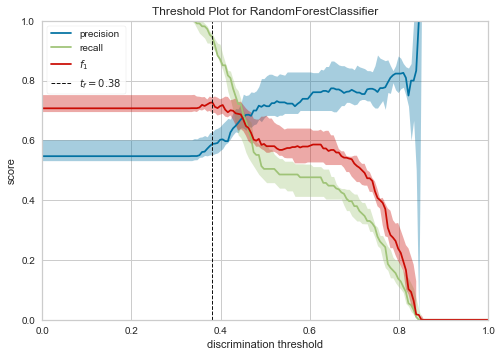

<AxesSubplot:title={'center':'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [527]:
visualizer =  DiscriminationThreshold(model,argmax='fscore',
                                    n_trials=5,
                                    # cv=btscv,
                                    is_fitted='auto',
                                    exclude="queue_rate")

# Converting Multiclass into 2 classes 1 and 0
y_test2 = [1 if i==-1 else i for i in y_test1]
y_train2 = [1 if i==-1 else i for i in y_train1]

visualizer.fit(X_train1,y_train2)
visualizer.score(X_test1,y_test2)
visualizer.show()


FPR and FNR

In [412]:
X_test
# y_test2

array([[ 625.        ,  601.59997559,  606.5       , ...,    0.        ,
           0.        ,    0.        ],
       [ 592.        ,  564.5       ,  564.5       , ...,    0.        ,
           0.        ,    0.        ],
       [ 552.        ,  522.20001221,  522.90002441, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [1043.69995117,  999.09997559, 1004.79998779, ...,    0.        ,
           0.        ,    0.        ],
       [1025.09997559,  990.20001221, 1022.40002441, ...,    0.        ,
           0.        ,    0.        ],
       [1052.40002441, 1026.19995117, 1052.40002441, ...,    0.        ,
           0.        ,    0.        ]])

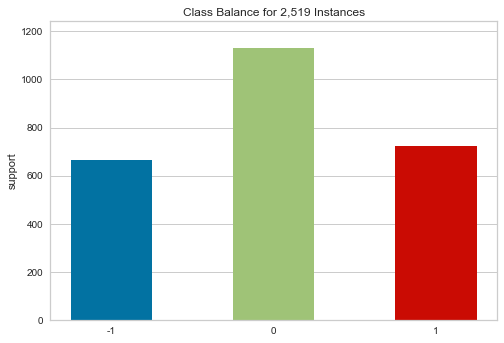

ClassBalance(ax=<AxesSubplot:title={'center':'Class Balance for 2,519 Instances'}, ylabel='support'>)

In [413]:
from yellowbrick.target import class_balance
class_balance(y.Labels)


In [414]:
from sklearn.model_selection import learning_curve
learning_curve(model,X,y.Labels,cv=btscv, scoring='f1_weighted')

(array([ 40, 130, 221, 311, 402]),
 array([[0.92428977, 0.91962264, 0.81173077, 0.87273936, 0.84173669],
        [0.68626374, 0.62685039, 0.7110517 , 0.75255118, 0.68627346],
        [0.55702388, 0.634367  , 0.56962602, 0.65971199, 0.64251866],
        [0.5401466 , 0.60010094, 0.47492918, 0.56625337, 0.57655018],
        [0.52915483, 0.5073646 , 0.47941768, 0.58078055, 0.58584659]]),
 array([[0.2660587 , 0.19628263, 0.41228738, 0.22470332, 0.25174446],
        [0.45644001, 0.3573732 , 0.22623581, 0.22470332, 0.12311215],
        [0.3323989 , 0.25426293, 0.30003   , 0.24549151, 0.42476883],
        [0.4427772 , 0.35670281, 0.2691248 , 0.31285211, 0.28041266],
        [0.4427772 , 0.25426293, 0.40535818, 0.16703457, 0.26552074]]))

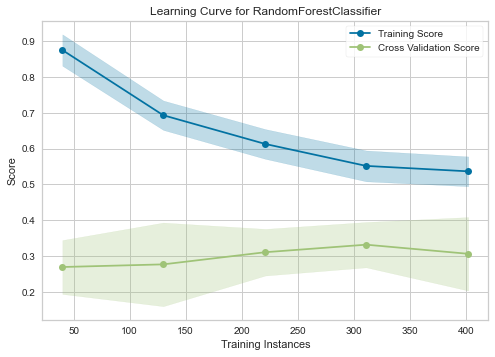

In [415]:
from yellowbrick.model_selection import LearningCurve
sizes = np.linspace(0.3, 1.0)
# , train_sizes=sizes
visualizer = LearningCurve(model,cv=btscv, scoring='f1_weighted', n_jobs=-1)
visualizer.fit(X,y.Labels)
visualizer.show();

### Converting both -1 and 1 into a single class

In [416]:
y_2class = pd.DataFrame(data=y.Labels.replace(to_replace=-1,value=1).values,columns=['Labels'], index= y.index)
y_2class.index = y.index
y_2class =pd.concat([y_2class,y.drop('Labels',axis=1)],axis=1).reindex(y.index)
y_2class.head(1)

,Labels,Close_2,Close_3,Adj_ret_2,Adj_ret_3,Adj_close_Up_Down_2,Adj_close_Up_Down_3,sample_weights
2012-01-03,0,251.0,263.3,0.01566,0.008391,1.0,1.0,1.103763


In [424]:
original, predicted = predictions_from_custom_cross_val(model,X, y_2class, custom_cv = btscv, sampled_weights=True)
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(original,predicted,labels=[0,1]).ravel()
FPR = fp/ (tn+fp)
FNR = fn/(tp+fn)
FPR, FNR

(0.2889908256880734, 0.445993031358885)

### FPR & FNR vs Threshold

In [425]:
thresholds = np.linspace(0,1,100)

fpr_ls = []
fnr_ls = []

#obtain probabilities
probs = model.predict_proba(X_test1)[:,1]
original,predicted_proba = probabilities_from_custom_cross_val(model,X, y_2class, custom_cv = btscv, sampled_weights=True)

for threshold in thresholds:

    #obtain class prediction based on threshold
    # preds = np.where(probs >= threshold,1,0)
    preds = np.where(predicted_proba >= threshold,1,0)
    
    #check if these are lined correctly
    tn, fp, fn, tp = confusion_matrix(original,preds,labels=[0,1]).ravel()
    FPR = fp/ (tn+fp)
    FNR = fn/(tp+fn)

    # Can even calculate recall and precision here

    fpr_ls.append(FPR)
    fnr_ls.append(FNR)

metrics = pd.concat([pd.Series(fpr_ls),pd.Series(fnr_ls)],axis=1)
metrics.columns = ['fpr','fnr']
metrics.index = thresholds

metrics

,fpr,fnr
0.000000,1.0,0.0
0.010101,1.0,0.0
0.020202,1.0,0.0
0.030303,1.0,0.0
0.040404,1.0,0.0
...,...,...
0.959596,0.0,1.0
0.969697,0.0,1.0
0.979798,0.0,1.0
0.989899,0.0,1.0


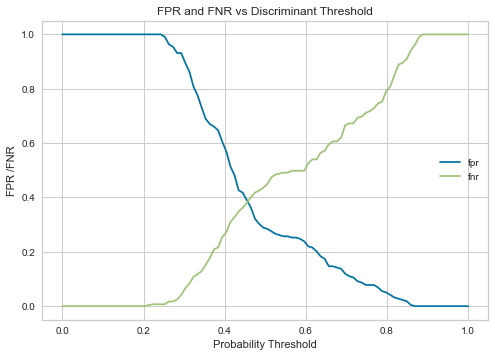

In [426]:
metrics.plot();
plt.xlabel('Probability Threshold')
plt.ylabel('FPR /FNR')
plt.title('FPR and FNR vs Discriminant Threshold');

In [431]:
#GEOMETRIC MEAN
from imblearn.metrics import (geometric_mean_score, make_index_balanced_accuracy, )
from sklearn.metrics import ( recall_score, accuracy_score, balanced_accuracy_score)

#True Positive Rate - Recall
print("TPR",recall_score(original, predicted,pos_label=1))

#True Negative Rate - Specificity?
print("TNR",recall_score(original, predicted,pos_label=0))

#geometric score - sqrt(TPR*TNR)
print("geometric score",geometric_mean_score(original,predicted))

TPR 0.554006968641115
TNR 0.7110091743119266
geometric score 0.6276177477864792


In [432]:
# Dominance - TPR - TNR
from xml import dom
def dominance(original,predicted):
    TPR = recall_score(original, predicted,pos_label=1)
    TNR = recall_score(original, predicted,pos_label=0)
    dominance = TPR - TNR
    return dominance

dominance(original,predicted)


-0.15700220567081158

In [433]:
# Index of Imbalanced Accuracy - didn't understand

gmean = make_index_balanced_accuracy(alpha=0.5, squared = True)(geometric_mean_score)
gmean(original,predicted)


0.3939040373365726

In [434]:
# Accuracy
accuracy_score(original,predicted), balanced_accuracy_score(original,predicted)

(0.6217821782178218, 0.6325080714765208)

In [435]:
# alpha is the desired balancing ratio you would like to reach, 
# so 0.5 means same number of observations on each class. 
# So if you want to understand the metric value on a balanced dataset you would use 0.5, 
# alternatively, you would use another value.

for i in np.linspace(0.0, 1.0, num=9).tolist():
    acc = make_index_balanced_accuracy(alpha=i, squared = True)(accuracy_score)
    print(i," : ",acc(original,predicted))

0.0  :  0.3866130771492991
0.125  :  0.37902568891759664
0.25  :  0.37143830068589423
0.375  :  0.36385091245419177
0.5  :  0.3562635242224893
0.625  :  0.34867613599078684
0.75  :  0.3410887477590844
0.875  :  0.3335013595273819
1.0  :  0.3259139712956795


In [436]:
# ROC Curve
from sklearn.metrics import (roc_auc_score, plot_roc_curve )
from yellowbrick.classifier import ROCAUC

roc_auc_score(original,predicted_proba)


0.6621967202634018

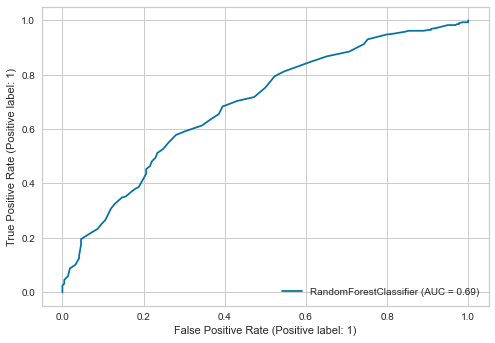

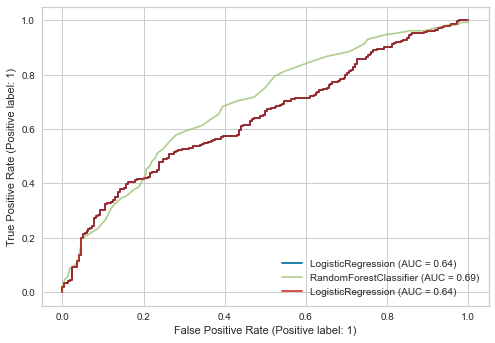

In [437]:
rf_mod = RandomForestClassifier()
logit_mod = LogisticRegression()

rf_mod.fit(X_train1,y_train2)
logit_mod.fit(X_train1,y_train2)

rf_disc = plot_roc_curve(rf_mod,X_test1, y_test2)
logit_disc = plot_roc_curve(logit_mod,X_test1, y_test2)

ax = plt.gca()
rf_disc.plot(ax=ax, alpha=0.8)
logit_disc.plot(ax=ax, alpha=0.8)


In [ ]:
# ROC-AUC with Yellowbrick

X,y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')
train_idx =  get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits=5, flatten=True)['train']
test_idx = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits=5, flatten=True)['test']
X_train  = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

rf_mod = RandomForestClassifier()
visualizer = ROCAUC(rf_mod)
visualizer.fit(X_train,y_train.Labels)
visualizer.score(X_test,y_test.Labels)
visualizer.show()


In [439]:
rf_mod = LogisticRegression()
visualizer = ROCAUC(rf_mod)
visualizer.fit(X_train,y_train.Labels)
visualizer.score(X_test,y_test.Labels)
visualizer.show()

ValueError: Found input variables with inconsistent numbers of samples: [2010, 1259]

In [440]:
from sklearn.metrics import plot_precision_recall_curve
from yellowbrick.classifier import PrecisionRecallCurve

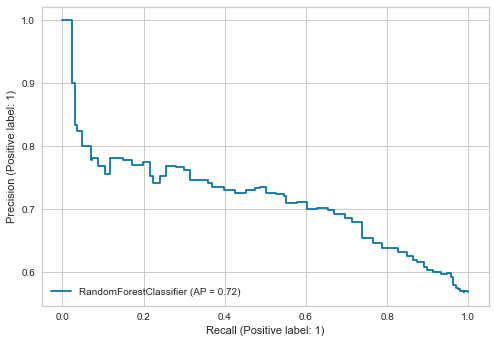

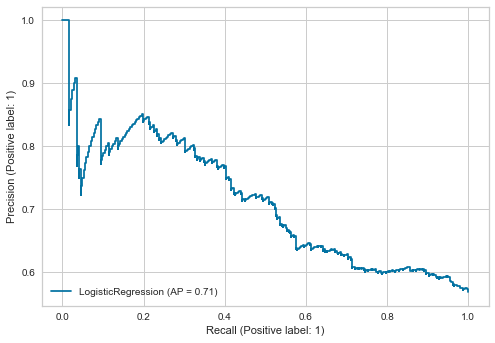

In [441]:
rf = RandomForestClassifier()
lr = LogisticRegression()

rf.fit(X_train1,y_train2)
lr.fit(X_train1,y_train2)

rf_disp = plot_precision_recall_curve(rf, X_test1, y_test2)
lr_disp = plot_precision_recall_curve(lr, X_test1, y_test2)


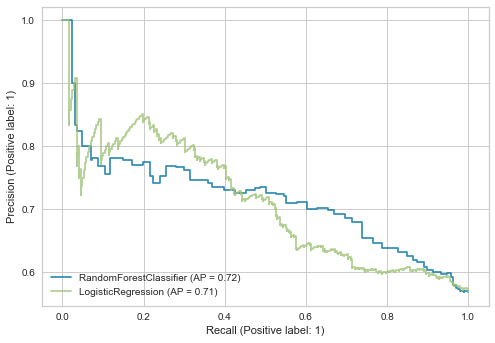

In [442]:
ax = plt.gca()
rf_disp.plot(ax=ax,alpha=0.8)
lr_disp.plot(ax=ax,alpha=0.8)

In [443]:

rf_mod = RandomForestClassifier()
visualizer = PrecisionRecallCurve(rf_mod)
visualizer.fit(X_train,y_train.Labels)
visualizer.score(X_test,y_test.Labels)
visualizer.show();

ValueError: Found input variables with inconsistent numbers of samples: [2010, 1259]

In [444]:
X.shape, y.shape

((2519, 725), (1764, 8))

In [445]:
# MULTICLASS

from locale import normalize
rf = RandomForestClassifier(random_state=1)

y.Labels.value_counts(normalize=True)

X_train_dict, X_test_dict, X_val_dict, y_train, y_test, y_val, sample_weights_train, sample_weights_test, sample_weights_val \
    = ttv_split(Variables, Response, test_size=0.50, Validation_date_start = '2022-01-01')

X, y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')
original_p, predicted_p = probabilities_from_custom_cross_val(rf,X,y,custom_cv=btscv,sampled_weights=False)
original, predicted = predictions_from_custom_cross_val(rf,X,y,custom_cv=btscv,sampled_weights=False)

In [446]:
predictions_from_prob = [row.argmax() for row in np.array(predicted_p)]
predictions_from_prob = [-1 if x==0 else 0 if x ==1 else 1 for x in predictions_from_prob]
(predictions_from_prob.count(-1), predictions_from_prob.count(0), predictions_from_prob.count(1)),(predicted.count(-1),predicted.count(0),predicted.count(1))


((222, 179, 104), (222, 179, 104))

In [448]:
p,r,f,s = precision_recall_fscore_support(original,predicted,labels=[-1,0,1],average=None) 
# when average None returns a metric per label, 
# use "macro" - (simple means of precision and recall values and then calculate fscore based on that)
# "weighted" - weighted by the support
# 'micro' - precision and recall when we take micro values are identical?
# Balanced_accuracy_score to identical to the recall calculated by the weighted average method above

p,r,f,s

(array([0.26576577, 0.59217877, 0.42307692]),
 array([0.45038168, 0.48623853, 0.28205128]),
 array([0.33427762, 0.53400504, 0.33846154]),
 array([131, 218, 156], dtype=int64))

In [449]:
cm = pd.DataFrame(confusion_matrix(original, predicted), index=Response['Labels'].unique(), columns=Response['Labels'].unique())
all_class_metric = metrics_from_cm(cm, lab = sorted(Response['Labels'].unique()))
all_class_metric

,precision,recall,fscore,specificity,fpr,accuracy,tp,tn,fp,fn,support
-1,59%,49%,53%,75%,25%,63%,106.0,214.0,73.0,112.0,218.0
0,27%,45%,33%,56%,44%,53%,59.0,211.0,163.0,72.0,131.0
1,42%,28%,34%,83%,17%,66%,44.0,289.0,60.0,112.0,156.0
macro,43%,41%,40%,71%,29%,61%,209.0,714.0,296.0,296.0,505.0
Wt_Avg,46%,41%,42%,72%,28%,62%,209.0,714.0,296.0,296.0,505.0


In [450]:
original.count(0), original.count(-1), original.count(1)

(218, 131, 156)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import binarize, label_binarize


In [ ]:
rf = OneVsRestClassifier(
    RandomForestClassifier(n_estimators=10, random_state=1, max_depth=1,n_jobs=-1))

original_p, predicted_p = probabilities_from_custom_cross_val(rf,X,y,custom_cv=btscv,sampled_weights=False)
original, predicted = predictions_from_custom_cross_val(rf,X,y,custom_cv=btscv,sampled_weights=False)

In [ ]:
# np.array(predicted)

In [ ]:
logit = LogisticRegression(random_state=1, multi_class='ovr') # for ove versus rest

In [ ]:
y_binarize = label_binarize(original_p,classes=[-1,0,1]) # check if classes like this are correct - the order
y_binarize[:9]

In [ ]:
original_p[:9]

In [ ]:
predicted_p[:9]

In [ ]:
predicted[:9]

In [ ]:
from sklearn.metrics import precision_recall_curve

# checking metrics for say class -1,0,1
p_m1,r_m1, thresholds_m1 = precision_recall_curve(y_binarize[:,0], np.array(predicted_p)[:,0])
p_0,r_0, thresholds_0 = precision_recall_curve(y_binarize[:,1], np.array(predicted_p)[:,1])
p_1,r_1, thresholds_1 = precision_recall_curve(y_binarize[:,2], np.array(predicted_p)[:,2])

In [ ]:
(len(thresholds_m1), len(p_m1), len(r_m1)),(len(thresholds_0), len(p_0), len(r_0)),(len(thresholds_1), len(p_1), len(r_1))

In [ ]:
precision_rf = dict()
recall_rf = dict()

for i in range(3):
    precision_rf[i], recall_rf[i], _ = precision_recall_curve(y_binarize[:,i], np.array(predicted_p)[:,i])

# plot the curves for each class

lab = -1
for i in range(3):
    plt.plot(recall_rf[i], precision_rf[i], label='class {}'.format(lab))
    lab = lab+1

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

In [ ]:
# A "micro-average": quantifying score on all classes jointly
# for random forests
precision_rf["micro"], recall_rf["micro"], _ = precision_recall_curve(
    y_binarize.ravel(), np.array(predicted_p).ravel(),
)

In [ ]:
i = "micro"

plt.plot(recall_rf[i], precision_rf[i], label='rf micro {}')

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve for class{}".format(i))
plt.show()

In [ ]:
# Using Yellowbrick

X_train_dict, X_test_dict, X_val_dict, y_train, y_test, y_val, sample_weights_train, sample_weights_test, sample_weights_val \
    = ttv_split(Variables, Response, test_size=0.50, Validation_date_start = '2022-01-01')

X,y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')
train_idx =  get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits=5, flatten=True)['train']
test_idx = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits=5, flatten=True)['test']
X_train  = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]


visualizer = PrecisionRecallCurve(
    rf, per_class=True, cmap="cool", micro=False,
)

visualizer.fit(X_train,y_train.Labels)
visualizer.score(X_test,y_test.Labels)
visualizer.show()

#Micro Yellowbrick

In [ ]:
visualizer = PrecisionRecallCurve(
    rf, cmap="cool", micro=True,)

visualizer.fit(X_train,y_train.Labels)
visualizer.score(X_test,y_test.Labels)
visualizer.show()                       # Finalize and show the figure

#ROCAUC Curve

In [ ]:
rf = OneVsRestClassifier(
    RandomForestClassifier(n_estimators=10, random_state=1, max_depth=1,n_jobs=-1))

original_p, predicted_p = probabilities_from_custom_cross_val(rf,X,y,custom_cv=btscv,sampled_weights=False)
original, predicted = predictions_from_custom_cross_val(rf,X,y,custom_cv=btscv,sampled_weights=False)
np.array(predicted_p)[:10]

In [ ]:
predicted[:10]

In [ ]:
pd.DataFrame(np.array(predicted_p)).sum(axis=1)[:10]

ROC Curve
Per class with Sklearn

In [ ]:
y_binarize = label_binarize(original_p,classes=[-1,0,1]) # check if classes like this are correct - the order
y_binarize[:9]

In [ ]:

# checking metrics for say class -1,0,1
fpr_m1, tpr_m1, thresholds_m1 = roc_curve(y_binarize[:,0], np.array(predicted_p)[:,0])
fpr_0, tpr_0, thresholds_0 = roc_curve(y_binarize[:,1], np.array(predicted_p)[:,1])
fpr_1, tpr_1, thresholds_1 = roc_curve(y_binarize[:,2], np.array(predicted_p)[:,2])
# false positive rate
# fpr_m1

In [ ]:
# now let's do these for all classes and capture the results in
# dictionaries, so we can plot the values afterwards

# determine the tpr and fpr
# at various thresholds of probability
# in a 1 vs all fashion, for each class

fpr_rf = dict()
tpr_rf = dict()

# for each class
for i in range(3):
    
    # determine tpr and fpr at various thresholds
    # in a 1 vs all fashion
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_binarize[:,i], np.array(predicted_p)[:,i])
    
# plot the curves for each class


for i in range(3):
    
    plt.plot(fpr_rf[i], tpr_rf[i], label='class {}'.format(i))

    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# probability vectors for all classes in 1-d vector
np.array(predicted_p).ravel()

In [ ]:
# see that the unravelled prediction vector has 3 times the size
# of the origina target

len(y_binarize), len(np.array(predicted_p).ravel())

In [ ]:
# A "micro-average": quantifying score on all classes jointly

# for random forests
# Compute micro-average ROC curve and ROC area
fpr_rf["micro"], tpr_rf["micro"], _ = roc_curve(
    y_binarize.ravel(), np.array(predicted_p).ravel(),
)
# now we plot them next to each other

i = "micro"

plt.plot(fpr_rf[i], tpr_rf[i], label='rf micro {}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ROC-AUC with sklearn

In [ ]:
# y_binarize, np.array(predicted_p)
macro_roc_auc_ovo = roc_auc_score(
    y_binarize, np.array(predicted_p), multi_class="ovo", average="macro")

weighted_roc_auc_ovo = roc_auc_score(
    y_binarize, np.array(predicted_p), multi_class="ovo", average="weighted")

macro_roc_auc_ovr = roc_auc_score(
    y_binarize, np.array(predicted_p), multi_class="ovr", average="macro")

weighted_roc_auc_ovr = roc_auc_score(
    y_binarize, np.array(predicted_p), multi_class="ovr", average="weighted")

print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))

print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

ROC curve and ROC-AUC
Per class with Yellobrick
Note:

In the cells below, we are passing to Yellobrick classes a model that is already fit. When we fit() the Yellobrick class, it will check if the model is fit, in which case it will do nothing.

If we pass a model that is not fit, and a multiclass target, Yellowbrick will wrap the model automatically with a 1 vs Rest classifier.

In [ ]:
rf =  RandomForestClassifier(
        n_estimators=10, random_state=39, max_depth=1, n_jobs=4,
)

# let's reconstitute the original format of
# the target for this calculations

y_test = np.argmax(y_test, axis=1)

y_test

In [ ]:
# Using Yellowbrick

X_train_dict, X_test_dict, X_val_dict, y_train, y_test, y_val, sample_weights_train, sample_weights_test, sample_weights_val \
    = ttv_split(Variables, Response, test_size=0.50, Validation_date_start = '2022-01-01')

X,y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')
train_idx =  get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits=5, flatten=True)['train']
test_idx = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits=5, flatten=True)['test']
X_train  = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]


visualizer = ROCAUC(
    rf, per_class=True, cmap="cool", micro=False,
)

visualizer.fit(X_train,y_train.Labels)
visualizer.score(X_test,y_test.Labels)
visualizer.show()

In [ ]:
# mICRO yELLOWBRICK

visualizer = ROCAUC(
    rf, per_class = False, cmap="cool", micro=True,
)

visualizer.fit(X_train,y_train.Labels)
visualizer.score(X_test,y_test.Labels)
visualizer.show()

### NEW WORK ENDS

In [ ]:
# **cross_val_score - accuracy_score**                                                      
# scoring https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules

# balanced_accuracy - sklearn.metrics.balanced_accuracy_score(y_true, y_pred, *, sample_weight=None, adjusted=False)
# The best value is 1 and the worst value is 0 when adjusted=False


def add_metrics(model,dataset,X_train_dict,X_test_dict,y_train,y_test,set='combined', sampled_weights=False):

    model_name = type(model).__name__
    metrics_list = ['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted','neg_log_loss']

    # Using BlockedTimeSeriesSplit cross val to calculate metrics
    X, y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')

    for metric in metrics_list:

        if sampled_weights:
        # cross_val_score with SAMPLE_WEIGHTS
            score = cross_val_score(model, X, y.Labels, cv=btscv, scoring = str(metric),fit_params={'sample_weight':y.sample_weights.values}) #,error_score="raise"
        else:
            score = cross_val_score(model, X, y.Labels, cv=btscv, scoring = str(metric)) #,error_score="raise"
            
        features_df.loc[(model_name, dataset),metric]= round(np.mean(score),2)

    # Calculating Class Wise Metrics - although predictions_from_custom_cross_val uses sample_weights to fit & predict but the metrics_from_cm doesn't use sample_weights
    original, predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv, sampled_weights=sampled_weights)
    cm = pd.DataFrame(confusion_matrix(original, predicted), index=Response['Labels'].unique(), columns=Response['Labels'].unique())
    
    # This is wrongly labeled - instead of showing -1,0,1 - its actually showing 0,-1,1 - change it appropriately
    all_class_metric = metrics_from_cm(cm, lab = sorted(Response['Labels'].unique()))
    
    # This is wrong LOOK AT sma.ipynb
    # Calculating pnl_score & sharpe - Adj_ret_3 is Log Returns so can simply add them after multiplying with predictions
    Test_adj_returns = y.Adj_ret_3.iloc[get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5)['test']].values.tolist()
    return_list = [a*b for a,b in zip(Test_adj_returns,predicted)]
    return_std = np.std(return_list) * np.sqrt(250) # Annualized
    pnl_score = np.exp(np.average(return_list)*250) - 1 # https://investmentcache.com/magic-of-log-returns-practical-part-2/
    sharpe_ratio = (pnl_score - 0.0)/return_std
    features_df.loc[(model_name, dataset),'pnl'] = pnl_score
    features_df.loc[(model_name, dataset),'sharpe'] = sharpe_ratio 

     
    # Calculating Kappa Score 
    if sampled_weights:
    # Kappa with SAMPLE_WEIGHTS
        sample_weights = y.sample_weights.iloc[get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5)['test']].values.tolist()
        kappa_score = cohen_kappa_score(original, predicted, sample_weight=sample_weights)
    else:
        kappa_score = cohen_kappa_score(original, predicted)
    
    
    features_df.loc[(model_name, dataset),'Kappa']= kappa_score
    
    # Insert the dataframe in a cell in features_df
    features_df.loc[(model_name, dataset),'ClassDf'] = np.array([])
    features_df.loc[(model_name, dataset),'ClassDf'].astype(object)
    features_df.loc[(model_name, dataset),'ClassDf'] =  [all_class_metric]
        

### To Check!!

In [ ]:

### Metrics from Confusion Matrix Custom Func
def metrics_from_cm(cm, lab):

    df = pd.DataFrame()
    pre = {}
    rec = {}
    tp = {}
    tn = {}
    fp = {}
    fn = {}
    weighted_average = {}
    for cat in lab:
        pre[cat] = np.nan_to_num(cm.loc[cat,cat]/cm.sum(axis=0).loc[cat], nan=0.0, posinf=0.0, neginf=0.0)
        rec[cat] = np.nan_to_num(cm.loc[cat,cat]/cm.sum(axis=1).loc[cat], nan=0.0, posinf=0.0, neginf=0.0)
        tp[cat] = cm.loc[cat, cat]
        tn[cat] = cm.drop(cat,axis=1).drop(cat,axis=0).sum().sum()
        fp[cat] = cm[cat].drop(cat).sum()
        fn[cat] = cm.loc[cat].drop(cat).sum()

    df = pd.concat([pd.DataFrame.from_dict(pre,orient='index', columns=['precision']),pd.DataFrame.from_dict(rec,orient='index', columns=['recall'])], axis=1)
    df['fscore'] = (2 * ((df.precision * df.recall) / (df.precision + df.recall))).fillna(0)
    df['tp'] = pd.Series(tp)
    df['tn'] = pd.Series(tn)
    df['fp'] = pd.Series(fp)
    df['fn'] = pd.Series(fn)

    df['specificity'] =  pd.Series(df.tn / (df.tn + df.fp))
    df['fpr'] = pd.Series(df.fp / (df.tn + df.fp))
    df['accuracy'] = (df.tp + df.tn) / (df.tp + df.tn + df.fp + df.fn)
    df['support'] = cm.sum(axis=1)

    main_metrics_list = ['precision', 'recall', 'fscore', 'specificity','fpr', 'accuracy']
    df_perc = df[main_metrics_list]
    df = pd.concat([df_perc,df.tp,df.tn,df.fp,df.fn,df.support], axis=1)

    # Weighted average
    for cols in df.columns:
        if cols in main_metrics_list:
            weighted_average[cols] = df[cols].dot(df.support)/df.support.sum()
        else:
            weighted_average[cols] = None

    df.loc['macro',main_metrics_list] = df[main_metrics_list].mean()

    weight_df = pd.DataFrame.from_dict(weighted_average,orient='index', columns=['Wt_Avg']).T
    df = pd.concat([df, weight_df], axis=0)

    # % Formatting
    for col in main_metrics_list:
        try:
            df[col] = df[col].mul(100).round(0).astype(int).astype(str).add('%')
        except:
            pass
    other_list = ['tp', 'tn', 'fp', 'fn', 'support']

    df.loc['macro', other_list] = df.loc[lab, other_list] .sum()
    df.loc['Wt_Avg', other_list] = df.loc[lab, other_list] .sum()

    return df

In [ ]:
# original, predicted = predictions_from_custom_cross_val(models[0],X, y, custom_cv = btscv, sampled_weights=True)
# predicted.count(1)/len(predicted), predicted.count(-1)/len(predicted), predicted.count(0)/len(predicted)

### Model Transformation Func

###### NOTE THE MODEL PIPELINES ARE BEING CHECKED/FITTED TO TRAINING DATA WHILE THE METRICS ARE calculated ON Set option in func argument

In [ ]:
# This function does the following steps:
# 1. Fill the dataset with passed X Variables
# 2. If transform = True is passed, it fits and transforms the X variable. If sampled_weights equals True, it provides test sample weights to the fitting transformation
# 3. Inserts model's basic data (length of features etc) into features_df, PRINTS X variables Shape & the features removed for each pipe step
# 4. Add metrics to features_df using Blocked Time Series Cross Validation with TEST set

def apply_model_transform(dataset,original_dataset, pipe, model,X_train_dict,X_test_dict,y_train,y_test, set='combined',manual_list = None, sampled_weights=False, transform = False):
    fill_with_dataset(dataset,manual_list,original_dataset)
    if transform: transform_features_space(dataset,pipe,sampled_weights)
    insert_and_print(model,dataset,pipe, manual_list)    
    add_metrics(model,dataset,X_train_dict,X_test_dict,y_train,y_test,set, sampled_weights)
    

### Create List of Models for both Classifiers & Regressors

In [ ]:
# Not using xgb_clf for now because it is too slow

rf_clf = RandomForestClassifier(n_estimators=200, max_depth=3, n_jobs=-1)
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1,eval_metric='mlogloss')

# models = [rf_clf,xgb_clf]
models = [rf_clf]

### Dataframe to Store Model Features & Metrics

In [ ]:
model_names = [type(m).__name__ for m in models]
dataset = 'Original'
multilevel_index = pd.MultiIndex.from_product([model_names,[dataset]],names=['Model', 'Dataset'])
cols_names = ['Model_Details','Num_Features','Features_List','Removed_Features'] + ['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted','neg_log_loss','Kappa','pnl','sharpe','ClassDf']
features_df = pd.DataFrame(columns=cols_names, index=multilevel_index)

### Initaiaze Dataset 'Original' as well as features_df

In [ ]:
# Takes 8.30 mins to run
for m in models:
    add_to_features_df(m,dataset='Original')
    add_metrics(model=m,dataset='Original',X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test,set='combined')
    
# Shapes
get_shapes(dataset = 'Original')

In [ ]:
features_df

### ***Functions to plot Blocked TimeSeries Split****

In [ ]:
n_splits = 5
cv = BlockingTimeSeriesSplit
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

print("The horizontal axis is the training set size while the vertical axis represents the cross-validation iterations. The folds used for training are depicted in blue and the folds used for validation are depicted in orange. The final horizontal bar are the FIVE [-2,-1,0,1,2] class labels for the response variable")
plot_timeseries_split(np.array(X_train_dict['Original']),np.array(y_train.Labels),n_splits,cmap_cv,cmap_data,cv)


### Remove all constant Variables
<div style="color: Green; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> Check why the following features have only one value
</div>

In [ ]:
# Issue with using XGBOOST - takes long time and gives warnigs Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
# Takes 4 minutes to run

warnings.filterwarnings("ignore")

dataset = 'Constant_weighted'
pipe = Pipeline([(dataset, DropConstantFeatures(tol=1, variables=None, missing_values='raise'))])

                     
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = None,sampled_weights=True, transform = True)
# apply_model_transform(dataset,'Original', pipe, models[1],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = None,sampled_weights=True, transform = True)

dataset = 'Constant'
pipe = Pipeline([(dataset, DropConstantFeatures(tol=1, variables=None, missing_values='raise'))])

apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = None, sampled_weights=False, transform = True)
# apply_model_transform(dataset,'Original', pipe, models[1],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = None, sampled_weights=False, transform = True)


In [ ]:
features_df.loc[('RandomForestClassifier','Constant_weighted'),'ClassDf'][0]

### Build 1 Model with 1 Feature only

**Check Kappa Score for both these models - one with sampled weights and other without**

In [ ]:
# original_dataset = 'Original'
# dataset = 'Enginered'
# model = models[0]
# feats_to_keep_list = ['BasisbyExpiry','YahooIndex']
# # insert_model_stats(dataset,original_dataset, feats_to_keep_list, model, set='combined')
# apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = feats_to_keep_list, sampled_weights=True, transform = False)


In [ ]:
# original_dataset = 'Original'
# dataset = 'Enginered_No_weights'
# model = models[0]
# feats_to_keep_list = ['BasisbyExpiry','YahooIndex']
# apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = feats_to_keep_list, sampled_weights=False, transform = False)

In [ ]:
# features_df.loc[('RandomForestClassifier','Enginered')]

In [ ]:
# features_df.loc[('RandomForestClassifier','Enginered')].loc['ClassDf'][0]

### Remove Quasi-constant features

In [ ]:
dataset = 'QuasiConstant'
pipe = Pipeline([(dataset, DropConstantFeatures(tol=0.95, variables=None, missing_values='raise'))])
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = None, sampled_weights=True, transform = True)

### Remove Duplicated Features

In [ ]:
dataset = 'Duplicated'
pipe = Pipeline([(dataset, DropDuplicateFeatures(variables=None, missing_values='raise')),])
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined', sampled_weights=True, transform = True)

### Remove Duplicated & Quasi Constant Features

In [ ]:
dataset = 'Dupl&QConstant'
pipe = Pipeline([(dataset, DropDuplicateFeatures(variables=None, missing_values='raise')),])
apply_model_transform(dataset,'QuasiConstant', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = None, sampled_weights=True, transform = True)


### Remove Correlated Features

In [ ]:
warnings.filterwarnings("ignore")

smart_correlation_estimator = models[0]
dataset = 'Correlated'
pipe = Pipeline([(dataset, SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=smart_correlation_estimator,scoring="roc_auc",cv=btscv,)),])
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test,set='combined', sampled_weights=True, transform = True)

### Remove Duplicated, Quasi Constant & Correlated Features

In [ ]:
warnings.filterwarnings("ignore")
smart_correlation_estimator = models[0]
dataset = 'Clean'
pipe = Pipeline([(dataset, SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=smart_correlation_estimator,scoring="roc_auc",cv=btscv,)),])
apply_model_transform(dataset,'Dupl&QConstant', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list=None, sampled_weights=True, transform = True)


### Clean1 - Drop constant, quasi Constant, duplicated and correlated features

In [ ]:
# Takes 9 minutes to run
warnings.filterwarnings("ignore")

smart_correlation_estimator = models[0]
dataset = 'Clean1'
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasiConstant', DropConstantFeatures(tol=0.95, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures(variables=None, missing_values='raise')),
    ('correlation', SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=smart_correlation_estimator,scoring="roc_auc",cv=btscv,)),])
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict,X_test_dict,y_train,y_test, set='combined',manual_list=None, sampled_weights=True, transform = True)

# apply_model_transform(dataset,'Original', pipe, models[1],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list=None, sampled_weights=False, transform = True)


In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1)

In [ ]:
# features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1).loc[[('RandomForestClassifier','emginereed_list_noweights'),('RandomForestClassifier','emginereed_list_weights'),('RandomForestClassifier','Clean'),('RandomForestClassifier','Original')]].T

### SELECTED ENGINEERED Feature List

##### NET SPEC Length

In [ ]:
dataset = 'emginereed_list_noweights'
manual_list = emginereed_list
pipe =  None
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = manual_list, sampled_weights=False, transform = False)

In [ ]:

dataset = 'emginereed_list_weights'
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = manual_list, sampled_weights=True, transform = True)


In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1).loc[[('RandomForestClassifier','emginereed_list_noweights'),('RandomForestClassifier','emginereed_list_weights'),('RandomForestClassifier','Clean'),('RandomForestClassifier','Original')]].T
# .loc[('RandomForestClassifier','Clean1')]

In [ ]:
import pandas as pd
%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

dataset = 'emginereed_list_noweights'

model = RandomForestClassifier()
model.fit(X_train_dict[dataset], y_train.Labels)

data = X_train_dict[dataset]

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances= importances.sort_values(by='Gini-importance')[-15:]
importances.plot(figsize=(18,6) ,kind='bar', rot=90);

**

In [ ]:
# var1 = "LumberBasis basis"
# var2 = "LumberExpiry Daystoexpiry"
# feat_name = 'BasisbyExpiry'

# #inplace operation  
# Variables = add_engineered_variables(Variables,var1,var2,func=np.divide,new_name=feat_name)

# # When Daystoexpiry equals 0, the value of BasisbyExpiry will be inf. so made it nan
# Variables.replace([np.inf, -np.inf], np.nan, inplace=True)


In [ ]:
# import statsmodels.api as sm

# def get_rolling_corr(df1,var1,window):
#     df = df1.copy(deep=True)
#     df.sort_index(ascending=True,inplace=True)
#     df =  df[var1].rolling(window=window).corr(Response['Close_2'])
#     return df.sort_index(ascending=False)

In [ ]:

# def add_yahoo_index(df1,yahoo_list,var2):
#     Variables.sort_index(ascending=False, inplace=True)
#     Response.sort_index(ascending=False, inplace=True)
#     final_df = Variables[yahoo_list].copy(deep=True)
#     price_corr = {}
#     for var1 in yahoo_list:
#         price_corr[var1] = Variables[var1].corr(Response[var2])
#         # print(var1,":",Variables[var1].corr(Response[var2]))
#     CorrwithLumber_df = pd.DataFrame.from_dict(price_corr, orient='index', columns=['CorrwithLumberPrice']).sort_values(by='CorrwithLumberPrice',ascending=False)

#     final_variable_list = CorrwithLumber_df[CorrwithLumber_df.CorrwithLumberPrice > 0.70].CorrwithLumberPrice.index.tolist()
#     final_df = Variables[final_variable_list].copy(deep=True)

#     rolling_df = pd.DataFrame(index = Variables.index)
#     for var in final_variable_list:
#         feat_name = var+"_ret"
#         rolling_df = pd.concat([rolling_df,pd.DataFrame(get_rolling_corr(final_df,var,5), columns=[var])],axis=1)
        
#     # Need to add both identical lines - else doesn't work?
#     rolling_df = rolling_df.replace([np.inf, -np.inf], np.nan).fillna(rolling_df.median())
#     rolling_df = rolling_df.replace([np.inf, -np.inf], np.nan).fillna(rolling_df.median())


#     pacf_dict = {}
#     for var in final_variable_list:
#         data = rolling_df[var].dropna().values
#         acf, ci = sm.tsa.acf(data, alpha=0.05)
#         pacf, ci = sm.tsa.pacf(data, alpha=0.05)
#         pacf_dict[var] = pacf[1]   
#         # pacf_dict[var] = acf[1]

#     pacf_df = pd.DataFrame.from_dict(pacf_dict, orient='index', columns=['PACF'])

#     rolling_df_auto = rolling_df.copy(deep=True)
#     for var in final_variable_list:
#         rolling_df[var] = rolling_df[var] * pacf_df.loc[var].values[0]

#     returns_df = pd.DataFrame(index = Variables.index)
#     for var in final_variable_list:
        
#         feat_name = var+"_ret"
#         returns_df = pd.concat([returns_df,pd.DataFrame((np.log(Variables) - np.log(Variables.shift(-1)))[var])],axis=1)

#     # Dropping Yahoo LBSF from both
#     rolling_df_auto.drop(rolling_df_auto.columns[0],axis=1, inplace=True)
#     returns_df.drop(returns_df.columns[0],axis=1, inplace=True)

#     YahooIndex = pd.DataFrame(data= np.diag(returns_df.dot(rolling_df_auto.T)), index = returns_df.index,columns = ['YahooIndex'])
#     df = df1.copy(deep=True)
#     df['YahooIndex'] = YahooIndex['YahooIndex']

#     return df
    

In [ ]:
# yahoo_list = ['Yahoo GSPC','Yahoo XHB','Yahoo XTN','Yahoo USDCADX','Yahoo GCF','Yahoo HGF','Yahoo CLF','Yahoo GCCIX','Yahoo LBSF','Yahoo RFP','Yahoo WFG','Yahoo IFPTO','Yahoo WY','Yahoo CFPTO']
# var2 = "Close_2"

# # Variables = add_yahoo_index(Variables,yahoo_list,'Close_2')
# Variables.replace(np.nan, 0, inplace=True)

In [ ]:
# Variables.replace(np.nan, 0, inplace=True)

In [ ]:
features_df.index

In [ ]:
'f1_weighted', 'neg_log_loss', 'cohen_kappa_score', 'precision_weighted','roc_auc_ovr_weighted'

In [ ]:
features_df.sort_values(by=['pnl','f1_weighted','recall_weighted','precision_weighted'],ascending=False, inplace=True)

In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1)

## Manual Feature Selection

To Do

**Engineered**
1. LB_High - LB_Low
2. Get Other Basis
3. Use some techincal Indicators

**Raw**
1. LB_Volume	
2. LB_openInterest



### Read List

In [ ]:
# pd.Series(Variables.columns.tolist()).to_csv('Variable_columns_names.csv',index=False)

manual_list = pd.read_excel('C:/source/2x4-data/app/model_building/ManualSelectList.xlsx',sheet_name='Variables', index_col=0)
manual_list = manual_list[manual_list.index == 1]
manual_list = manual_list.values.tolist()
manual_list = [x for xs in manual_list for x in xs]

In [ ]:
warnings.filterwarnings("ignore")

original_dataset='Original'

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasiConstant', DropConstantFeatures(tol=0.90, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures(variables=None, missing_values='raise')),
    ('correlation', SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=model,scoring="precision_weighted",cv=btscv,)),])

dataset='ManualSelection_Weighted_Transformed'
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = manual_list, sampled_weights=True, transform = True)

dataset='ManualSelection'
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = manual_list, sampled_weights=False, transform = False)

dataset='ManualSelection_Transformed'
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = manual_list, transform = True)


In [ ]:
dataset='ManualSelection_Try_1'
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict,X_test_dict,y_train,y_test, set='combined',manual_list = manual_list, sampled_weights=False, transform = True)


In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1)

In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features'],axis=1).loc[('RandomForestClassifier','ManualSelection_Weighted_Transformed')]['ClassDf'][0]

### Mutual Information BY COHORT & Total

In [ ]:
dataset = 'Original'
X, y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')
X.columns = Variables_midx.columns
train_idx  = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = True)['train']
test_idx = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = True)['test']
X_train = X.iloc[train_idx]
y_train1 = y.iloc[train_idx]


top_cohort_variable = pd.DataFrame(index = Variables_midx.columns.get_level_values(0).unique(), columns=['Variable','Score','Col_name'])
for outer_col in Variables_midx.columns.get_level_values(0).unique():
    
    sel_  = SelectKBest(mutual_info_classif, k=1).fit(X_train.loc[:,(outer_col,)], y_train1.Labels)
    
    selected_col = [x for x,y in zip(pd.DataFrame(X_train.loc[:,(outer_col,)]).columns,sel_.get_support()) if y]
    # col_name = tuple(outer_col+','+selected_col[0])

    selected_col_score = [x for x,y in zip(sel_.scores_,sel_.get_support()) if y]
    # top_cohort_variable[outer_col] = [selected_col[0],selected_col_score[0]]
    # cols = pd.MultiIndex.from_product([[outer_col], (selected_col[0])])
    top_cohort_variable.loc[outer_col,'Variable'] = selected_col[0]
    top_cohort_variable.loc[outer_col,'Score'] = selected_col_score[0]

    try:
        top_cohort_variable.loc[outer_col,'Col_name'] = outer_col+" "+selected_col[0]
    except:
        print(outer_col, selected_col[0])

    # inner_cols = [x for x in pd.DataFrame(X_train.loc[:,(outer_col,)]).columns]    
    # print(sel_.scores_)
    # print(sel_.get_support())
    # print(outer_col,selected_col[0])
    # print(selected_col_score)
    # print(top_cohort_variable[outer_col])
    # print('\n')

    # TA_df.columns = [('TA_',x) for x in TA_df.columns]
    
# Make column names same as Variables
for col in top_cohort_variable.Col_name:
    top_cohort_variable.loc[top_cohort_variable['Col_name'] == col, 'Col_name'] = str(col).translate(str.maketrans('', '', string.punctuation)).lstrip().rstrip()


# Keeping only top 95% percentile of variables in terms of mutual info score - Enter 1- percentile value in the below line
top_cohort_variable = top_cohort_variable[top_cohort_variable.Score > top_cohort_variable.Score.quantile(.05)]

top_cohort_variable.sort_values(by=['Score'],ascending=False, inplace=True)

top_cohort_variable.plot(x='Variable',y='Score',kind='bar', figsize=(20,10));


In [ ]:


warnings.filterwarnings("ignore")
base_estimator = RandomForestClassifier(n_estimators=1, criterion='entropy', bootstrap=False)
model = BaggingClassifier(base_estimator=base_estimator, n_estimators=100, max_features=1.0)
dataset='Top_K_Cohort_MI_Weighted_Transformed_50%PERCENTILE'

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasiConstant', DropConstantFeatures(tol=0.90, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures(variables=None, missing_values='raise')),
    ('correlation', SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=model,scoring="precision_weighted",cv=btscv,)),])

apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = top_cohort_variable.Col_name.values.tolist(), sampled_weights=True, transform = True)


### FEATURE IMPORTANCE BY COHORT

In [ ]:
dataset = 'Original'
X, y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')
X.columns = Variables_midx.columns
train_idx  = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = True)['train']
test_idx = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = True)['test']
X_train = X.iloc[train_idx]
y_train1 = y.iloc[train_idx]


top_cohort_variable = pd.DataFrame(index = Variables_midx.columns.get_level_values(0).unique(), columns=['Variable','Score','Col_name'])
for outer_col in Variables_midx.columns.get_level_values(0).unique():
    

    sel_ = SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=10))

    sel_.fit(X_train.loc[:,(outer_col,)], y_train1.Labels)

    
    sel_  = SelectKBest(mutual_info_classif, k=1).fit(X_train.loc[:,(outer_col,)], y_train1.Labels)
    
    selected_col = [x for x,y in zip(pd.DataFrame(X_train.loc[:,(outer_col,)]).columns,sel_.get_support()) if y]
    # col_name = tuple(outer_col+','+selected_col[0])

    selected_col_score = [x for x,y in zip(sel_.scores_,sel_.get_support()) if y]
    # top_cohort_variable[outer_col] = [selected_col[0],selected_col_score[0]]
    # cols = pd.MultiIndex.from_product([[outer_col], (selected_col[0])])
    top_cohort_variable.loc[outer_col,'Variable'] = selected_col[0]
    top_cohort_variable.loc[outer_col,'Score'] = selected_col_score[0]

    try:
        top_cohort_variable.loc[outer_col,'Col_name'] = outer_col+" "+selected_col[0]
    except:
        print(outer_col, selected_col[0])

    # inner_cols = [x for x in pd.DataFrame(X_train.loc[:,(outer_col,)]).columns]    
    # print(sel_.scores_)
    # print(sel_.get_support())
    # print(outer_col,selected_col[0])
    # print(selected_col_score)
    # print(top_cohort_variable[outer_col])
    # print('\n')

    # TA_df.columns = [('TA_',x) for x in TA_df.columns]
    
# Make column names same as Variables
for col in top_cohort_variable.Col_name:
    top_cohort_variable.loc[top_cohort_variable['Col_name'] == col, 'Col_name'] = str(col).translate(str.maketrans('', '', string.punctuation)).lstrip().rstrip()


# Keeping only top 95% percentile of variables in terms of mutual info score - Enter 1- percentile value in the below line
top_cohort_variable = top_cohort_variable[top_cohort_variable.Score > top_cohort_variable.Score.quantile(.5)] #0.05

top_cohort_variable.sort_values(by=['Score'],ascending=False, inplace=True)

top_cohort_variable.plot(x='Variable',y='Score',kind='bar', figsize=(20,10));


In [ ]:
models[0]

In [ ]:
warnings.filterwarnings("ignore")

model = models[1]
dataset='Top_K_Cohort_FeatImp_Weighted_Transformed_50%PERCENTILE'

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures(variables=None, missing_values='raise')),
    ('correlation', SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=model,scoring="f1_weighted",cv=btscv,)),])

apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = top_cohort_variable.Col_name.values.tolist(), sampled_weights=True, transform = True)


In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1)

In [ ]:
STOP HERE


In [ ]:
sel_  = SelectKBest(mutual_info_classif, k=20).fit(X_train, y_train1.Labels)
X_train.columns[sel_.get_support()]

In [ ]:
# determine the mutual information

# mi = mutual_info_classif(X_train, y_train1.Labels)
# mi = pd.Series(mi)
# mi.index = X_train.columns
# mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
# plt.ylabel('Mutual Information')

t = SelectKBest(mutual_info_classif).fit(X_train, y_train1.Labels)
t

In [ ]:
t.scores_.tolist()

In [ ]:
# pd.DataFrame(data = [t.scores_.tolist(),X_train.columns], columns = ['Score','Selected']).sort_values(by=['Score'],ascending=False)

**yellowbricks**

In [ ]:
dataset = 'ManualSelection'
X,y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')
train_idx =  get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits, flatten=True)['train']
test_idx = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits, flatten=True)['test']
X_train  = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

from yellowbrick.classifier import (ClassificationReport,  DiscriminationThreshold,)
rf = RandomForestClassifier(max_depth=4, n_estimators=20, n_jobs=-1)
visualizer = ClassificationReport(rf, support=True)

visualizer.fit(X_train, y_train.Labels)        # Fit the visualizer and the model
visualizer.score(X_test , y_test.Labels)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

In [ ]:
dataset = 'ManualSelection'
X,y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')
rf = RandomForestClassifier(max_depth=4, n_estimators=20, n_jobs=-1)
original, predicted = predictions_from_custom_cross_val(rf,X, y, custom_cv = BlockingTimeSeriesSplit(n_splits=5), sampled_weights=True)
# cm = pd.DataFrame(confusion_matrix(original, predicted), index=Response['Labels'].unique(), columns=Response['Labels'].unique())

In [ ]:
len(X), len(y)

In [ ]:
len(X_train_dict['ManualSelection']), len(y_train)

In [ ]:

model = LogisticRegression(multi_class="auto", solver="liblinear")

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=[-1,-0,1])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features'],axis=1).loc[('RandomForestClassifier','ManualSelection')]['ClassDf'][0]

### Save Below

In [ ]:
X = pd.concat([X_train_dict['Original'],X_test_dict['Original']],axis=0)
y = pd.concat([y_train,y_test],axis=0)
model = models[0]

In [ ]:
com1_original, com1_predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv, sampled_weights=False)
com2_original, com2_predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv, sampled_weights=True)
com1_original == com2_original, com1_predicted == com2_predicted


In [ ]:

pd.DataFrame(data = [pd.Series(com1_predicted).value_counts().sort_index(), pd.Series(com1_original).value_counts().sort_index()], index = ['predicted','original']).T



In [ ]:
pd.DataFrame(data = [pd.Series(com2_predicted).value_counts().sort_index(), pd.Series(com2_original).value_counts().sort_index()], index = ['predicted','original']).T


In [ ]:
# class_weight='balanced'



In [ ]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
class_weights = compute_class_weight(class_weight = "balanced",classes= lab, y = y.Labels)
computed_sample_weights = compute_sample_weight('balanced', y.Labels)
class_weights

In [ ]:
computed_sample_weights

In [ ]:
group_df = pd.DataFrame(data = [computed_sample_weights, y.Labels], index = ['computed_sample_weights','Labels']).T
group_df
group_df.groupby('Labels').mean()

In [ ]:
Response[['Labels','sample_weights']].groupby('Labels').sum()
# Response[['Labels','sample_weights']].groupby('Labels').mean()


In [ ]:

create_bins_data(Response,'sample_weights',10)

In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1)

In [ ]:
features_df.loc[('RandomForestClassifier','ManualSelection')]['ClassDf'][0]

In [ ]:
features_df.loc[('RandomForestClassifier','Clean1')]['ClassDf'][0]

In [ ]:
feats_to_keep_list = ['LumberContractSpreads FirstSecond','lumbermovingaverages MA200']

In [ ]:
original_dataset = 'Original'
dataset = 'Spread_1-2_wts'
model = models[0]
feats_to_keep_list = ['LumberContractSpreads FirstSecond','lumbermovingaverages MA200']
# insert_model_stats(dataset,original_dataset, feats_to_keep_list, model, set='combined', sampled_weights= True)


In [ ]:
X = pd.concat([X_train_dict[dataset],X_test_dict[dataset]]).sort_index()
y = pd.concat([y_train,y_test]).sort_index() 


original, predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv)
cm = pd.DataFrame(confusion_matrix(original, predicted), index=lab, columns=lab)
all_class_metric = metrics_from_cm(cm, lab = sorted(Response['Labels'].unique()))

In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1)

In [ ]:
cm

In [ ]:
features_df.loc[('RandomForestClassifier','Spread_1-2_wts')]['ClassDf'][0]

In [ ]:
features_df.loc[('RandomForestClassifier','Spread_1-2')]['ClassDf'][0]

In [ ]:
features_df.loc[('RandomForestClassifier','Spread_1-2_MA200')]['ClassDf'][0]


In [ ]:
features_df.loc[('RandomForestClassifier','Spread_1-2')]

In [ ]:
features_df.loc[('RandomForestClassifier','Spread_1-2_MA200')]


In [ ]:
X_train_dict[dataset].iloc[:, : 8]

In [ ]:
# 'log_loss'


from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs = SFS(model, 
           k_features=6, # the more features we want, the longer it will take to run
           forward=True, 
           floating=True, # see the docs for more details in this parameter
           verbose=2, # this indicates how much to print out intermediate steps
           scoring='f1_weighted', 
           cv=btscv,
           n_jobs=-1,
            
         )

weights = np.abs(y.Adj_ret_3.values)

sfs = sfs.fit(X, y.Labels,sample_weight=weights)

In [ ]:
df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
df.sort_values('avg_score', inplace=True, ascending=False)
df

In [ ]:
#### TEST 
dataset = 'Original'
X = X_train_dict[dataset].sort_index()
y = y_train.sort_index() 

model = RandomForestClassifier(n_estimators=1, max_depth=1, n_jobs=-1)
  

efs1 = EFS(model, 
           min_features=1,
           max_features=1,
           scoring='f1',
           print_progress=True,
           cv=btscv)

efs1 = efs1.fit(X, y.Labels)



In [ ]:
print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

In [ ]:
dataset = 'Clean1'
model = RandomForestClassifier(n_estimators=5, max_depth=2, n_jobs=-1)
X = pd.concat([X_train_dict[dataset],X_test_dict[dataset]]).sort_index()
y = pd.concat([y_train,y_test]).sort_index()    

efs1 = EFS(model, 
           min_features=1,
           max_features=2,
           scoring='f1',
           print_progress=True,
           cv=btscv)

efs1 = efs1.fit(X, y.Labels)

print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)



In [ ]:
efs1.subsets_

In [ ]:
df = pd.DataFrame.from_dict(efs1.get_metric_dict()).T
df.sort_values('avg_score', inplace=True, ascending=False)
df

In [ ]:
features_df

In [ ]:
STOP HERE 

In [ ]:
model = models[0]
model.fit(X_train_dict['Clean1'], y_train.Labels)
plot_confusion_matrix(model, X_test_dict['Clean1'], y_test.Labels)

In [ ]:
# Fitting the model here since it takes > 1 min
xgb = XGBClassifier(n_estimators=200, max_depth=3, n_jobs=-1,eval_metric='mlogloss')
xgb.fit(X_train_dict['Clean1'], y_train.Labels)

In [ ]:

y_pred = xgb.predict(X_test_dict['Clean1'])
df1 = pd.DataFrame(np.transpose(precision_recall_fscore_support(y_test.Labels, y_pred, average=None)),columns=['precision', 'recall', 'fscore', 'support'], index=lab)
df1




In [ ]:

from sklearn.model_selection import cross_val_predict

model = models[0]
model.fit(X_train_dict['Clean1'], y_train.Labels)
y_pred = model.predict(X_test_dict['Clean1'])

# y_pred = cross_val_score(model, X_train_dict['Clean1'], y_train.Labels, cv=5)
# y_pred


In [ ]:
y_pred.shape

In [ ]:
y_train.Labels.shape

In [ ]:
# Fitting the model here since takes ~ 1.30 minute
# model = models[1]
# model.fit(X_train_dict['Clean1'], y_train.Labels)
# y_pred = model.predict(X_test_dict['Clean1'])

In [ ]:


model = models[0]

X = X_test_dict['Clean1'].sort_index()
y = y_test.sort_index()  

original, predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv)

cm = pd.DataFrame(confusion_matrix(original, predicted), index=lab, columns=lab)
cm


In [ ]:
280/1386

In [ ]:
len(original), y_test.Labels.shape, len(predicted)

In [ ]:
all_class_metric = metrics_from_cm(cm, lab = sorted(Response['Labels'].unique()))
all_class_metric


In [ ]:
print(classification_report(original, predicted)) 

In [ ]:
# features_df.drop(['Model_Details','Features_List','Removed_Features'],axis=1)

In [ ]:
precision_recall_fscore_support(original, predicted, average='weighted')

In [ ]:
print(classification_report(y_test.Labels, y_pred))

In [ ]:
# Insert the dataframe in a cell in features_df
# features_df['to_delete'] = None
# features_df['to_delete'].astype(object)
# features_df.loc[('RandomForestClassifier','Original'),'to_delete'] =  [all_class_metric]

In [ ]:
# features_df.loc[('RandomForestClassifier','Original'),'to_delete'][0]

### Cross Entropy - Negative Log Liklehood or Log Loss - Custom Function Implementation

In [ ]:
# Lower The Better

model = models[0]
model.fit(X_train_dict['Original'], y_train.Labels)
y_prob = model.predict_proba(X_test_dict['Original'])

# This line required to convert for custom implementation from normal labels to indexed labels
y_actuals = y_test.Labels.replace(to_replace=sorted(y_test.Labels.unique()), value=list(range(len(y_test.Labels.unique())))).values

# Custom function to compute negative log loss
nll = np.mean([-np.log(y_prob[i,j]) for i,j in zip(range(y_prob.shape[0]),y_actuals)])
print(nll) 

In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1).loc[('RandomForestClassifier',)]

In [ ]:
print(log_loss(y_actuals, y_prob))
print(log_loss(y_test.Labels, y_prob))

In [ ]:
from sklearn.metrics import log_loss

model = models[0]
dataset = 'Clean'
X = pd.concat([X_train_dict[dataset],X_test_dict[dataset]]).sort_index()
y = pd.concat([y_train,y_test]).sort_index() 

LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
scores = cross_val_score(model, X, y.Labels, cv=btscv, scoring=LogLoss)
scores.mean()

In [ ]:
LogLoss._select_proba_binary(predicted,y_test.Labels.values) 

In [ ]:

probabilities_from_custom_cross_val(model,X, y, custom_cv = btscv)

In [ ]:
from sklearn.model_selection import cross_val_predict

# proba = cross_val_predict(model, X, y, cv=btscv, method='predict_proba')

In [ ]:
STOP HERE

****TO USE***

In [ ]:
fpr_, fnr_, thresholds_ = det_curve(y_test.Close_Up_Down, y_pred)
model.fit(X_train_dict['Original'], y_train.Close_Up_Down)
y_prob = model.predict_proba(X_test_dict['Original'])
y_pred = model.predict(X_test_dict['Original'])

y_pred = (clf.predict_proba(X_test_dict['Original'])[:,1] >= p).astype(bool) # set threshold as 0.3
fpr, tpr, threshold = roc_curve(y_test.Close_Up_Down, y_pred,)


model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
model.fit(X_train_dict['Clean'], y_train.Close_Up_Down)
y_pred = model.predict(X_test_dict['Clean'])
confusion_matrix(y_test.Close_Up_Down, y_pred)
plot_confusion_matrix(clf, X_test_dict['Clean'], y_test.Close_Up_Down,);
clsf_report = classification_report(y_test.Close_Up_Down, y_pred, output_dict=True)
pd.DataFrame(clsf_report)

### Univariate Selection Methods - Mostly just examine linear relationships

#### Mutual Information

In [ ]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False, inplace = True)

# Plot
# mi.plot.bar(figsize=(20, 6))
# plt.ylabel('Mutual Information')

# select features
sel_ = SelectKBest(mutual_info_classif, k=15).fit(X_train, y_train)

# display features
X_train.columns[sel_.get_support()]

#### Chi-square Statistic - only suited for classification!                                         
https://www.udemy.com/course/feature-selection-for-machine-learning/learn/lecture/22495182#questions
https://github.com/solegalli/feature-selection-for-machine-learning/blob/main/05-Filter-Statistical-Tests/05.2-Fisher-score.ipynb

In [ ]:
# calculate the chi2 p_value between each of the variables and the target
# chi2 returns 2 arrays, one contains the F-Scores which are then evaluated against the chi2 distribution to obtain the pvalue. The pvalues are in the second array

# Input X must be non-negative
X_train_non_negative = X_train[X_train.columns[((X_train < 0).sum(axis=0) == 0).values]]
f_score = chi2(X_train_non_negative.fillna(0), y_train)
pvalues = pd.Series(f_score[1])
pvalues.index = X_train_non_negative.columns
pvalues.sort_values(ascending=True, inplace = True)
extremely_low_p_values = len(pvalues[pvalues < 1e-100])
sel_ = SelectKBest(chi2, k= extremely_low_p_values).fit(X_train_non_negative, y_train)
X_train_non_negative.columns[sel_.get_support()] # display features

# X_train = sel_.transform(X_train)
# X_test = sel_.transform(X_test)

#### Anova - tests 2 samples have same mean

Assumptions:
Sample are independant & normally distributed, homegeneity of variance

In [ ]:
# calculate the univariate statistical measure between each of the variables and the target
# similarly to chi2, the output is one array with f-scores and one array with the pvalues

univariate = f_classif(X_train, y_train)
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=True, inplace = True) # The smaller the p_value the more predictive the feature is

pvalue_above_5_percent = len(univariate[univariate < 0.05])
sel_ = SelectKBest(f_classif, k=pvalue_above_5_percent).fit(X_train, y_train)
features_to_keep = sel_.get_feature_names_out()
features_to_keep

# select features
# X_train_anova = sel_.transform(X_train)
# X_test_anova = sel_.transform(X_test)

# # numpy array to dataframe
# X_train_anova = pd.DataFrame(X_train_anova)
# X_train_anova.columns = features_to_keep

# X_test_anova = pd.DataFrame(X_test_anova)
# X_test_anova.columns = features_to_keep

# X_train_anova.shape, X_test_anova.shape



### Wrapper Methods

### Embedded Methods | Tree Importance

In [ ]:
# Selects features whose importance is greater than the threshold. - Thershold is the mean importance of all features
sel_ = SelectFromModel(RandomForestClassifier(n_estimators=300,  max_depth=3, n_jobs=-1)).fit(X_train, y_train)
selected_features = X_train.columns[sel_.get_support()]
print(len(selected_features))
TopNFeatures = pd.DataFrame(index = sel_.estimator_.feature_names_in_.tolist(),data = sel_.estimator_.feature_importances_, columns = ['Imp']).sort_values(by='Imp',ascending=False).head(20).index.tolist()
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20);

In [ ]:
TopNFeatures

### Embedded Methods | Tree Importance Recursively

In [ ]:
# Takes 1:44 mins to run
sel_ = RFE(RandomForestClassifier(n_estimators=100,  max_depth=3, n_jobs=-1), n_features_to_select=30).fit(X_train, y_train)
selected_features = X_train.columns[sel_.get_support()]
print(len(selected_features))
selected_features


In [ ]:
rf = RandomForestClassifier(n_estimators=200, max_depth=3, n_jobs=-1)
rf.fit(X_train[selected_features].fillna(0), y_train)
y_pred = rf.predict(X_test[selected_features].fillna(0))
y_valid_pred = rf.predict(X_val[selected_features].fillna(0))
print("Test Accuracy:", accuracy_score(y_test.fillna(0), y_pred))
print("Validation Accuracy:", accuracy_score(y_val.fillna(0), y_valid_pred))


In [ ]:
print('Train set')
pred = rf.predict_proba(X_train[selected_features])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

print('Test set')
pred = rf.predict_proba(X_test[selected_features])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

print('Validation set')
pred = rf.predict_proba(X_val[selected_features])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_val, pred[:, 1])))

### Feature Selection by Random Shuffling

In [ ]:
# Takes 1 min to run - You can use this procedure with any machine learning algorithm

rf = RandomForestClassifier(n_estimators=50, max_depth=2, n_jobs=-1)

sel = SelectByShuffling(
    variables=None, # automatically examine all numerical variables
    estimator=rf, # the ML model
    scoring='roc_auc', # the metric to evaluate
    threshold=0,# the maximum performance drop allowed to select the feature
    cv=btscv, # cross validation
)

sel.fit(X_train, y_train)


In [ ]:
sel.initial_model_performance_ # performance of model trained with all features

In [ ]:
# pd.Series(sel.performance_drifts_).sort_values(ascending=False).plot.bar(figsize=(16,6));

In [ ]:
# features that will be removed

print(len(sel.features_to_drop_))
# remove features

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)
X_val = sel.transform(X_val)

X_train.shape, X_test.shape

In [ ]:
rf.fit(X_train, y_train)
print( 'train auc score: ',roc_auc_score(y_train, (rf.predict_proba(X_train))[:,1]))
print('test auc score: ', roc_auc_score(y_test, (rf.predict_proba(X_test))[:, 1]))
print('Validation auc score: ', roc_auc_score(y_val, (rf.predict_proba(X_val))[:, 1]))

In [ ]:
X_train.columns

### Recursive Feature Elimination

In [ ]:
model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=10,
)

In [ ]:
# NOT WORKING

sel = RecursiveFeatureElimination(
    variables=None, # automatically evaluate all numerical variables
    estimator = model, # the ML model
    scoring = 'roc_auc', # the metric we want to evalute
    threshold = 0.0005, # the maximum performance drop allowed to remove a feature
    cv=btscv, # cross-validation
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
# sel.fit(X_train, y_train)

In [ ]:
sel.initial_model_performance_

In [ ]:
# performance of model trained using all features
sel.initial_model_performance_

In [ ]:
# importance of all features based of initial model
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [ ]:
# Number of features that will be removed

len(sel.features_to_drop_)

### Random Forest

In [ ]:
features = list(X_train.columns)
rf = RandomForestClassifier(n_estimators=200, max_depth=3)
rf.fit(X_train[features].fillna(0), y_train)

importance = pd.concat([pd.Series(features),pd.Series(rf.feature_importances_)], axis=1)
importance.columns = ['feature', 'importance']
importance.sort_values(by=['importance'], ascending=False, inplace=True)
y_pred = rf.predict(X_test[features].fillna(0))
y_valid_pred = rf.predict(X_val[features].fillna(0))

print("Test Accuracy:", accuracy_score(y_test.fillna(0), y_pred))
print("Validation Accuracy:", accuracy_score(y_val .fillna(0), y_valid_pred))

### Compare the performance in machine learning algorithms

In [ ]:
X_train_basic_filter.shape, X_test_basic_filter.shape, X_train.shape, X_test.shape

In [ ]:

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(n_estimators=300,  max_depth=3, n_jobs=-1)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

In [ ]:
# filter methods - basic
run_randomForests(X_train_basic_filter,X_test_basic_filter,y_train, y_test)

In [ ]:
# Final model
run_randomForests(X_train, X_test, y_train, y_test)

### Logistic Regression

In [ ]:
# create a function to build logistic regression and compare performance in train and test set

from sklearn.metrics import confusion_matrix

def run_logistic(X_train, X_test, y_train, y_test):
    
    # function to train and test the performance of logistic regression
    logit = LogisticRegression(penalty='l1', random_state=44, max_iter=1000, solver='liblinear')
    logit.fit(X_train, y_train)
    print('Train set')
    pred = logit.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = logit.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

scaler = StandardScaler().fit(X_train)

run_logistic(scaler.transform(X_train),
             scaler.transform(X_test),
                  y_train, y_test)

### 
<div style="color: DarkBlue; font-size:22px;" class="alert alert-block alert-warning"> 
<b>Pipelines:</b> Final Code will look like this but for now work through issues above 
</div>

In [ ]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasiConstant', DropConstantFeatures(tol=0.9, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures(variables=None, missing_values='raise')),
    ('correlation', SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.9,missing_values="raise",selection_method="variance",estimator=rf,scoring="roc_auc",cv=btscv,)),])


pipe.fit(X_train)

# remove features
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)
X_val = pipe.transform(X_val)

X_train.shape, X_test.shape, X_val.shape


In [ ]:
print(len(pipe.named_steps['constant'].features_to_drop_))
pipe.named_steps['duplicated'].features_to_drop_

# NOT USING - for reference

### Correlated Features - Brute Force approach

In [ ]:
def correlation(dataset, threshold):
    
    col_corr = set()
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        
        for j in range(i):
            
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
             
                print(abs(corr_matrix.iloc[i, j]),":", corr_matrix.columns[i], "<< - >>", corr_matrix.columns[j])
                colname = corr_matrix.columns[j]
                
                # and add it to our correlated set
                col_corr.add(colname)
                
    return col_corr

# corr_features = correlation(X_train, 0.9)
# len(set(corr_features))


In [ ]:
# corr_features = correlation(X_train, 0.9)

### Correlated Features - Second Approach

In [ ]:
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.9]
corrmat = corrmat[corrmat < 1] # Not Interested in the correlation with 1 since will be with the same variable
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

In [ ]:
grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))



In [ ]:
# for group in correlated_groups:
#     print(group)
#     print()

In [ ]:
#Choose Group Index
group_index = 1

group = correlated_groups[group_index]
var = group.feature1.unique()[0]

# add all features of the group to a list
features = list(group['feature2'].unique())+[var]

rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train[features].fillna(0), y_train)

importance = pd.concat([pd.Series(features),pd.Series(rf.feature_importances_)], axis=1)
importance.columns = ['feature', 'importance']

print(var)
importance.sort_values(by='importance', ascending=False)


In [ ]:
# for feature in group['feature2']:
#     plt.scatter(X_train[var], X_train[feature])
#     plt.xlabel(feature)
#     plt.ylabel(var)
#     plt.show()

### Just an example to show one group of how smart correlation works

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

group = sel.correlated_feature_sets_[0]

# build random forest with cross validation for each feature
for f in group:
    
    model = cross_validate(
        rf,
        X_train[f].to_frame(),
        y_train,
        cv=btscv,
        return_estimator=False,
        scoring='accuracy',
    )

#  scoring='roc_auc' does not support categorical data.

    print(f, model["test_score"].mean())

****TO USE***

In [ ]:
fpr_, fnr_, thresholds_ = det_curve(y_test.Close_Up_Down, y_pred)
model.fit(X_train_dict['Original'], y_train.Close_Up_Down)
y_prob = model.predict_proba(X_test_dict['Original'])
y_pred = model.predict(X_test_dict['Original'])

y_pred = (clf.predict_proba(X_test_dict['Original'])[:,1] >= p).astype(bool) # set threshold as 0.3
fpr, tpr, threshold = roc_curve(y_test.Close_Up_Down, y_pred,)


model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
model.fit(X_train_dict['Clean'], y_train.Close_Up_Down)
y_pred = model.predict(X_test_dict['Clean'])
confusion_matrix(y_test.Close_Up_Down, y_pred)
plot_confusion_matrix(clf, X_test_dict['Clean'], y_test.Close_Up_Down,);
clsf_report = classification_report(y_test.Close_Up_Down, y_pred, output_dict=True)
pd.DataFrame(clsf_report)

### Classification Model Evaluation metrics
1. cross_val_score
2. Area under the ROC Curve
3. Confusion Matrix
4. Confusion Report

https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics


In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
cross_val_score(model, Variables, Response.Close_Up_Down, cv = 2, scoring = 'accuracy')

In [ ]:
model = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1)
cross_val_score(model, X_train_dict['Original'], y_train.Labels, cv = 5,scoring='roc_auc_ovo_weighted')

In [ ]:
model = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1)
cross_val_score(model, X_train_dict['Clean1'], y_train.Labels, cv = 5,scoring='roc_auc_ovo')

In [ ]:
model.fit(X_train_dict['Original'], y_train.Close_Up_Down)
y_prob = model.predict_proba(X_test_dict['Original'])
y_pred = model.predict(X_test_dict['Original'])


In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
clf.fit(X_train_dict['Original'], y_train.Close_Up_Down)

for p in [0.475,0.5,0.525]:
    
    y_pred = (clf.predict_proba(X_test_dict['Original'])[:,1] >= p).astype(bool) # set threshold as 0.3
    fpr, tpr, threshold = roc_curve(y_test.Close_Up_Down, y_pred,)
    print("tpr:",tpr)
    print("fpr:",fpr)
    print("threshold:",threshold)
    print(p,": ",roc_auc_score(y_test.Close_Up_Down, y_pred))
    print("\n")

https://stackoverflow.com/questions/45715018/scikit-learn-how-to-plot-probabilities

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
clf.fit(X_train_dict['Clean'], y_train.Close_Up_Down)
plt.figure(figsize=(12,5))
prediction = clf.predict_proba(X_test_dict['Clean'])[:,1]
plt.hist(prediction[y_test.Close_Up_Down==-1], bins=100, label='Negatives')
plt.hist(prediction[y_test.Close_Up_Down==1], bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=10)
plt.ylabel('Number of records in each bucket', fontsize=10)
# plt.xlim(0,1)
plt.legend(fontsize=10)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

In [ ]:
def plot_roc_auc_curve(y_test, model_set, model):
    model.fit(X_train_dict[model_set], y_train.Close_Up_Down)
    y_prob_positive = model.predict_proba(X_test_dict[model_set])[:,1]
    print(f"ROC_AUC_SCORE: {roc_auc_score(y_test.Close_Up_Down, y_prob_positive):.2f}%")
    fpr, tpr, threshold = roc_curve(y_test.Close_Up_Down, y_prob_positive,)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)

plot_roc_auc_curve(y_test, 'Original', model)
# plot_roc_auc_curve(y_test, 'Original', y_test)

In [ ]:
(y_pred == [-1 if x[0] > 0.5 else 1 for x in y_prob]).all()

In [ ]:
# Took 5:20 mins
# from sklearn.ensemble import GradientBoostingClassifier
# model = GradientBoostingClassifier(n_estimators=100, max_depth=3)
# cross_val_score(model, Variables, Response.Close_Up_Down, cv = 5).min()

**Confusion Matrix**

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
model.fit(X_train_dict['Clean'], y_train.Close_Up_Down)
y_pred = model.predict(X_test_dict['Clean'])
confusion_matrix(y_test.Close_Up_Down, y_pred)

In [ ]:
pd.crosstab(y_test.Close_Up_Down, y_pred, rownames=['Actual'], colnames=['Predicted'])

In [ ]:
import seaborn as sns

conf_mat = confusion_matrix(y_test.Close_Up_Down, y_pred)
sns.heatmap(pd.crosstab(y_test.Close_Up_Down, y_pred, rownames=['Actual'], colnames=['Predicted']), annot=True)

In [ ]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(8,5))

ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues');
plt.xlabel('Actual');
plt.ylabel('Predicted');




In [ ]:
plot_confusion_matrix(clf, X_test_dict['Clean'], y_test.Close_Up_Down,);

In [ ]:
plot_confusion_matrix(clf, X_val_dict['Clean'], y_val.Close_Up_Down,);

**Clasification Report**

In [ ]:
clsf_report = classification_report(y_test.Close_Up_Down, y_pred, output_dict=True)
pd.DataFrame(clsf_report)

In [ ]:
fpr

In [ ]:
print(classification_report(y_test.Close_Up_Down, y_pred))

In [ ]:
clsf_report['-1.0']['f1-score']

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, det_curve
precision_score(y_test.Close_Up_Down, y_pred)

In [ ]:
fpr_, fnr_, thresholds_ = det_curve(y_test.Close_Up_Down, y_pred)

In [ ]:
fpr_

In [ ]:
fnr_

In [ ]:
thresholds_